In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import uuid
import re
import json
from pandas.plotting import register_matplotlib_converters
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

charging = pd.read_csv("./charging_cleaned.csv", encoding = "ISO-8859-1")
weather = pd.read_csv("./weather_cleaned.csv", encoding = "ISO-8859-1")

In [2]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

<h1> Task 2 </h1>

<h2> Task 2 a.) - Showing daily demand

2 approaches for daily demand: 

1. show every single hour
2. divide day in morning, noon ect.

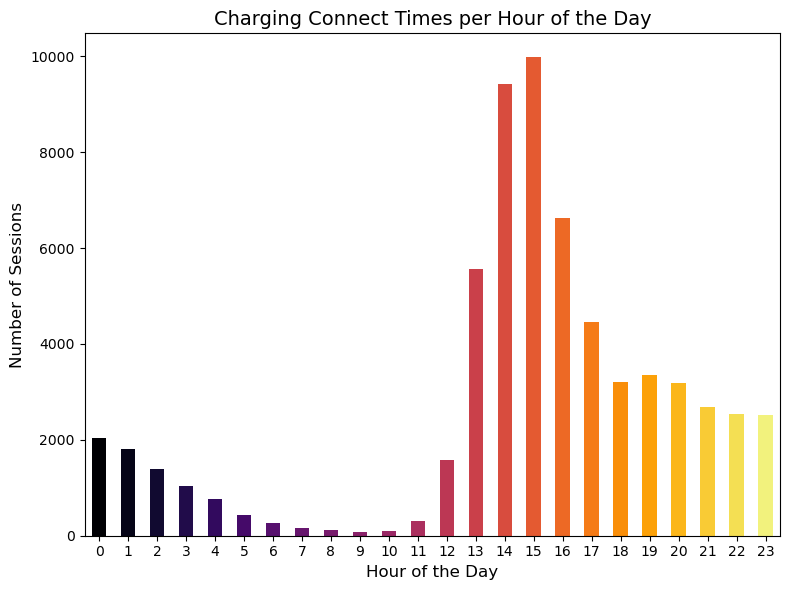

In [6]:
#first approach
charging['hour_of_day'] = charging['connectionTime'].dt.hour

cmap = plt.get_cmap("inferno")  # You can change this to any other colormap like 'plasma', 'inferno', etc.
colors = [cmap(i / 24) for i in range(24)]

plt.figure(figsize=(8, 6))
sessions_per_hour = charging.groupby('hour_of_day').size()

sessions_per_hour.plot(kind='bar', color=colors)

plt.xticks(range(0, 24), rotation=0)
plt.title('Charging Connect Times per Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()



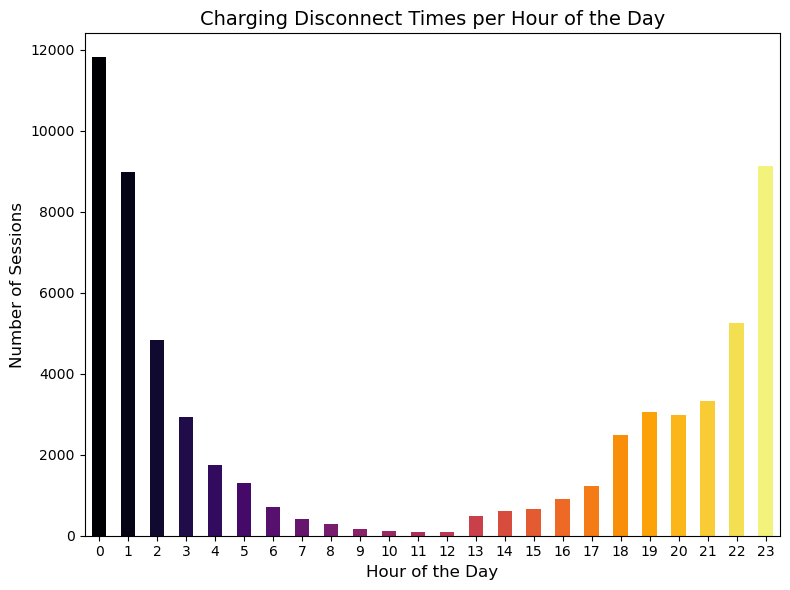

In [7]:
#first approach
charging['hour_of_day'] = charging['disconnectTime'].dt.hour

cmap = plt.get_cmap("inferno")  # You can change this to any other colormap like 'plasma', 'inferno', etc.
colors = [cmap(i / 24) for i in range(24)]

plt.figure(figsize=(8, 6))
sessions_per_hour = charging.groupby('hour_of_day').size()

sessions_per_hour.plot(kind='bar', color=colors)

plt.xticks(range(0, 24), rotation=0)
plt.title('Charging Disconnect Times per Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()


<h1>Idea: Show 2 bar charts per hour next to each other -> one for disconnectTime and one for connectTime <h1>

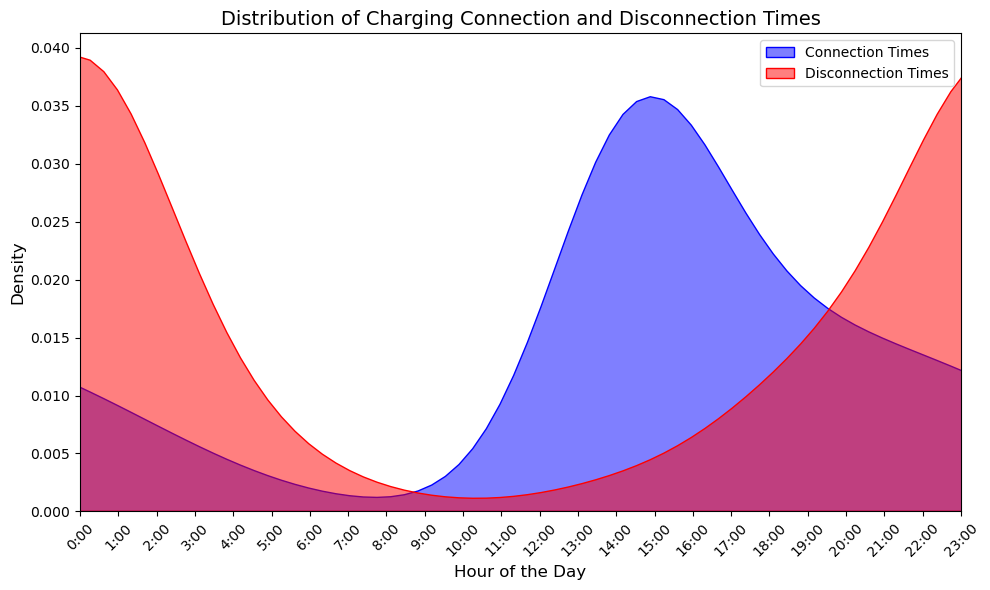

In [9]:

# Extract hour of the day for connection and disconnection times
charging['connection_hour'] = charging['connectionTime'].dt.hour
charging['disconnection_hour'] = charging['disconnectTime'].dt.hour

# Extend the data to handle circular nature (wrap-around at midnight)
def extend_circular_data(data):
    return np.concatenate([data - 24, data, data + 24])

connection_hours_extended = extend_circular_data(charging['connection_hour'])
disconnection_hours_extended = extend_circular_data(charging['disconnection_hour'])

# Create a KDE plot for both connection and disconnection times
plt.figure(figsize=(10, 6))
sns.kdeplot(connection_hours_extended, label='Connection Times', color='blue', fill=True, alpha=0.5, clip=(-24, 47))
sns.kdeplot(disconnection_hours_extended, label='Disconnection Times', color='red', fill=True, alpha=0.5, clip=(-24, 47))

# Add labels, title, and legend
plt.title('Distribution of Charging Connection and Disconnection Times', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Set x-axis ticks and labels to show 24-hour format
plt.xticks(range(0, 24), [f'{i}:00' for i in range(24)], rotation=45)
plt.xlim(0, 23)  # Explicitly set x-axis limits to 0-23

plt.legend()
plt.tight_layout()
plt.show()

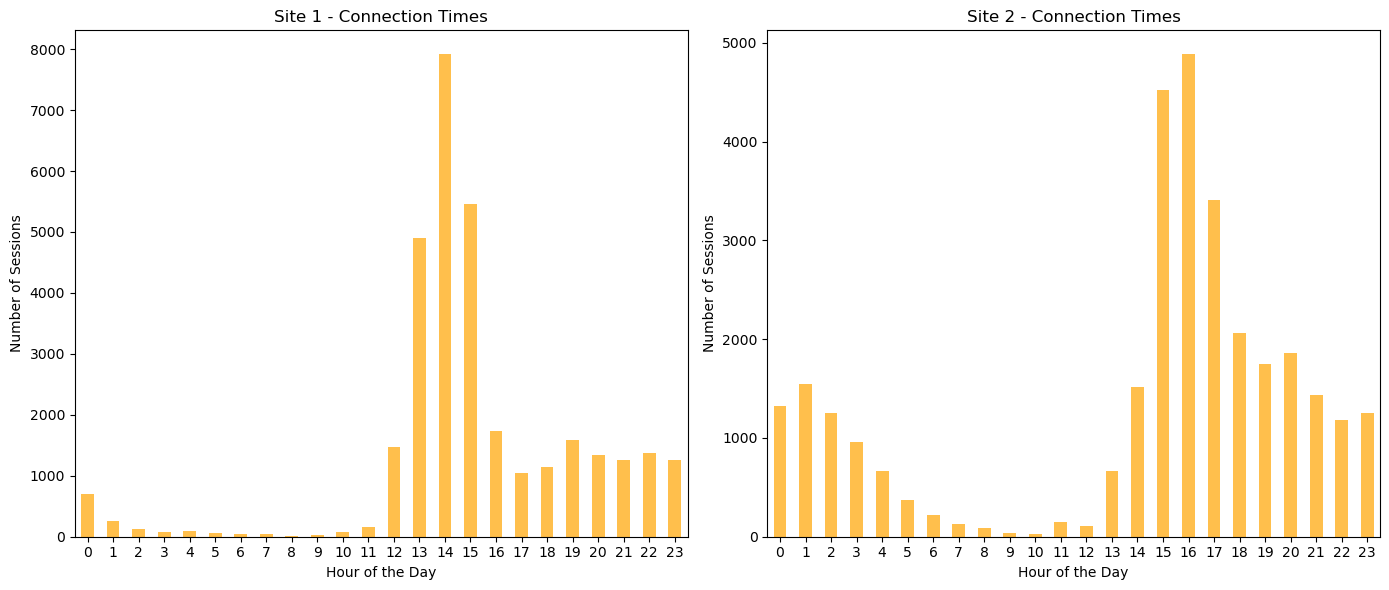

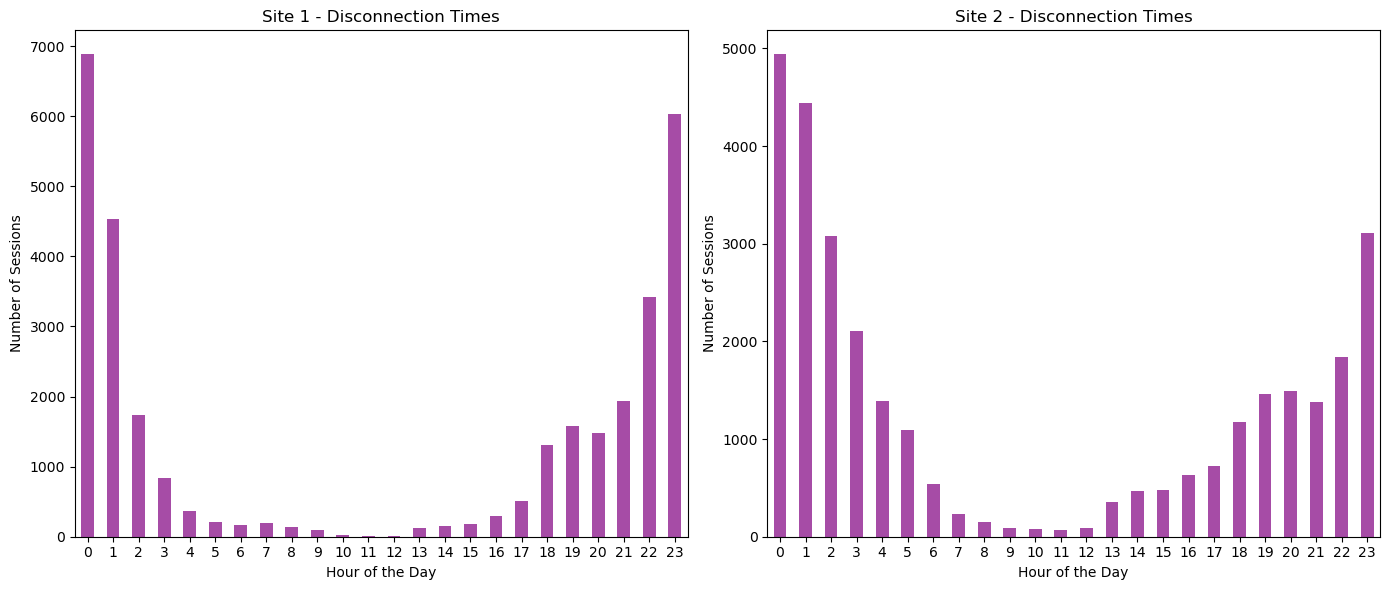

In [10]:
# Define the sites
sites = charging['siteID'].unique()

# Plot connection times per site
plt.figure(figsize=(14, 6))

for i, site in enumerate(sites, 1):
    # Filter data for the site
    site_data = charging[charging['siteID'] == site]
    
    # Calculate hourly connection counts
    connection_hours = site_data['connectionTime'].dt.hour.value_counts().sort_index()
    
    # Plot
    plt.subplot(1, 2, i)  # 1 row, 2 columns for 2 sites
    connection_hours.plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Site {site} - Connection Times')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Sessions')
    plt.xticks(range(0, 24), rotation=0)

plt.tight_layout()
plt.show()

# Plot disconnection times per site
plt.figure(figsize=(14, 6))

for i, site in enumerate(sites, 1):
    # Filter data for the site
    site_data = charging[charging['siteID'] == site]
    
    # Calculate hourly disconnection counts
    disconnection_hours = site_data['disconnectTime'].dt.hour.value_counts().sort_index()
    
    # Plot
    plt.subplot(1, 2, i)  # 1 row, 2 columns for 2 sites
    disconnection_hours.plot(kind='bar', color='purple', alpha=0.7)
    plt.title(f'Site {site} - Disconnection Times')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Sessions')
    plt.xticks(range(0, 24), rotation=0)

plt.tight_layout()
plt.show()

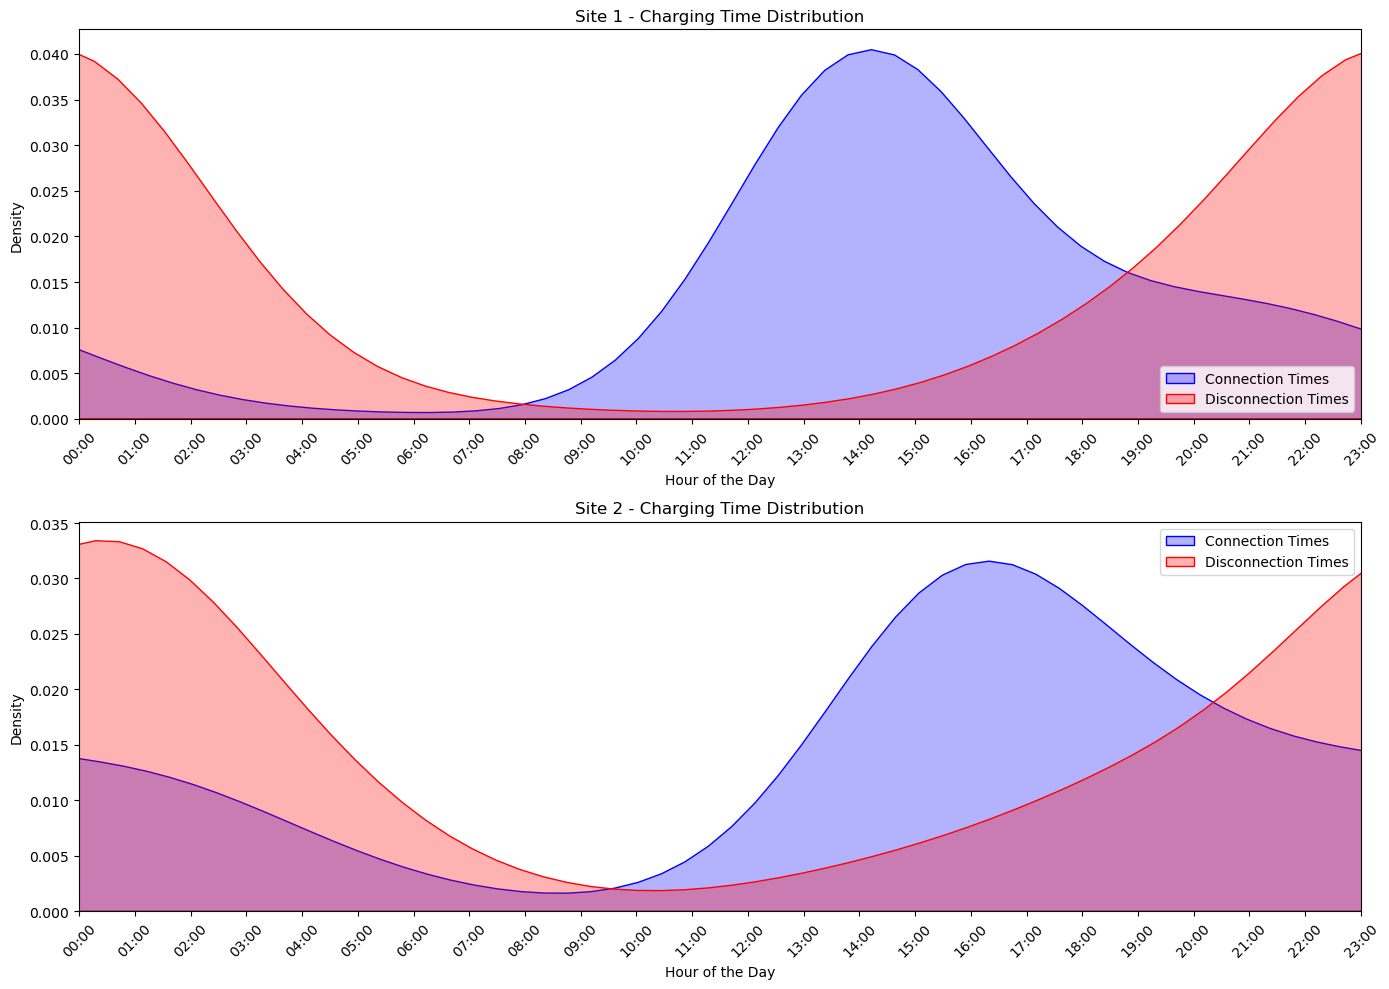

In [11]:
# Function to extend circular data for KDE
def extend_circular_data(data):
    return np.concatenate([data - 24, data, data + 24])

# Plot KDEs for connection and disconnection times per site
plt.figure(figsize=(14, 10))

for i, site in enumerate(sites, 1):
    # Filter data for the site
    site_data = charging[charging['siteID'] == site]
    
    # Extend circular data for KDE
    connection_extended = extend_circular_data(site_data['connectionTime'].dt.hour)
    disconnection_extended = extend_circular_data(site_data['disconnectTime'].dt.hour)
    
    # Plot KDEs for the site
    plt.subplot(2, 1, i)  # 2 rows, 1 column for 2 sites
    sns.kdeplot(connection_extended, label='Connection Times', color='blue', fill=True, alpha=0.3)
    sns.kdeplot(disconnection_extended, label='Disconnection Times', color='red', fill=True, alpha=0.3)
    plt.title(f'Site {site} - Charging Time Distribution')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Density')
    plt.xticks(range(0, 24), [f'{h:02}:00' for h in range(24)], rotation=45)
    plt.xlim(0, 23)
    plt.legend()

plt.tight_layout()
plt.show()

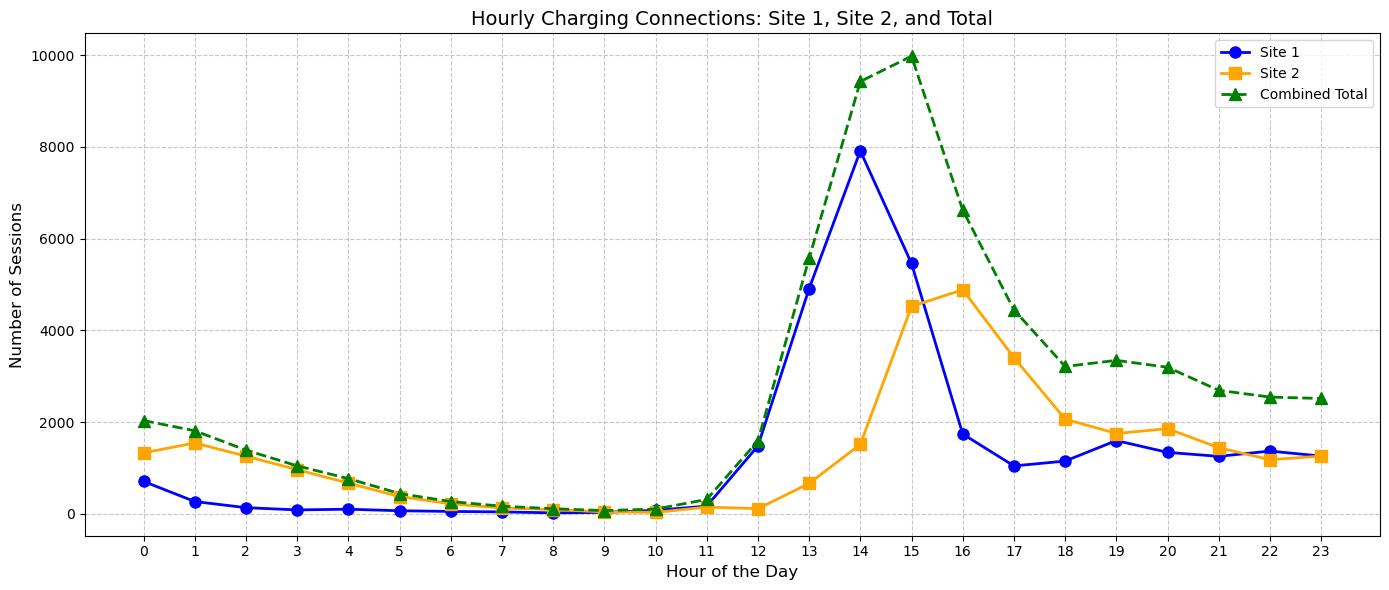

In [12]:
# Calculate hourly connection counts for each site
site1 = charging[charging['siteID'] == 1]
site2 = charging[charging['siteID'] == 2]

# Group by hour for each site
hourly_site1 = site1['connectionTime'].dt.hour.value_counts().sort_index().reindex(range(0,24), fill_value=0)
hourly_site2 = site2['connectionTime'].dt.hour.value_counts().sort_index().reindex(range(0,24), fill_value=0)

# Calculate total (combined) connections
hourly_total = hourly_site1 + hourly_site2

plt.figure(figsize=(14, 6))

# Plot Site 1
plt.plot(hourly_site1.index, hourly_site1.values, 
         color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, 
         label='Site 1')

# Plot Site 2
plt.plot(hourly_site2.index, hourly_site2.values, 
         color='orange', marker='s', linestyle='-', linewidth=2, markersize=8, 
         label='Site 2')

# Plot Combined Total
plt.plot(hourly_total.index, hourly_total.values, 
         color='green', marker='^', linestyle='--', linewidth=2, markersize=8, 
         label='Combined Total')

# Formatting
plt.title('Hourly Charging Connections: Site 1, Site 2, and Total', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

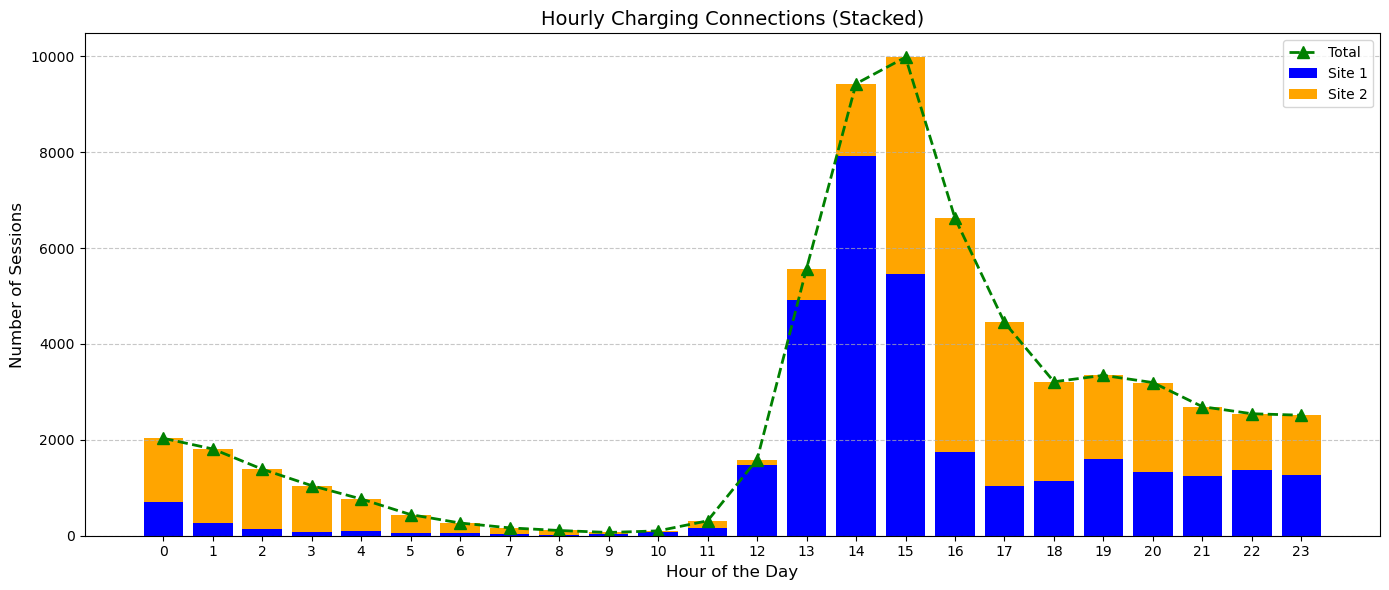

In [13]:
plt.figure(figsize=(14, 6))

# Plot stacked bars
plt.bar(hourly_site1.index, hourly_site1.values, label='Site 1', color='blue')
plt.bar(hourly_site2.index, hourly_site2.values, bottom=hourly_site1.values, 
        label='Site 2', color='orange')

# Add total line (optional)
plt.plot(hourly_total.index, hourly_total.values, 
         color='green', marker='^', linestyle='--', linewidth=2, markersize=8, 
         label='Total')

# Formatting
plt.title('Hourly Charging Connections (Stacked)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

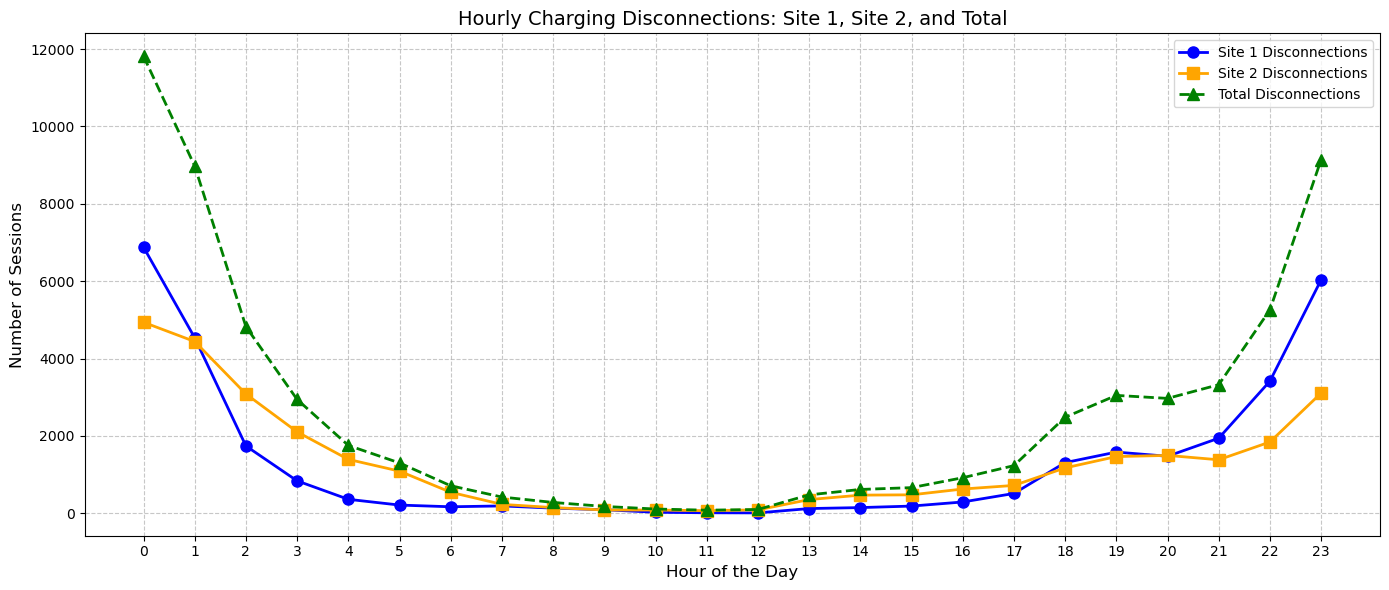

In [14]:
# Calculate hourly disconnection counts for each site
site1_disconnect = charging[charging['siteID'] == 1]
site2_disconnect = charging[charging['siteID'] == 2]

# Group by hour for each site
hourly_site1_disconnect = site1_disconnect['disconnectTime'].dt.hour.value_counts().sort_index().reindex(range(0,24), fill_value=0)
hourly_site2_disconnect = site2_disconnect['disconnectTime'].dt.hour.value_counts().sort_index().reindex(range(0,24), fill_value=0)

# Calculate total (combined) disconnections
hourly_total_disconnect = hourly_site1_disconnect + hourly_site2_disconnect

# Plot
plt.figure(figsize=(14, 6))

# Plot Site 1 Disconnections
plt.plot(hourly_site1_disconnect.index, hourly_site1_disconnect.values, 
         color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, 
         label='Site 1 Disconnections')

# Plot Site 2 Disconnections
plt.plot(hourly_site2_disconnect.index, hourly_site2_disconnect.values, 
         color='orange', marker='s', linestyle='-', linewidth=2, markersize=8, 
         label='Site 2 Disconnections')

# Plot Combined Total Disconnections
plt.plot(hourly_total_disconnect.index, hourly_total_disconnect.values, 
         color='green', marker='^', linestyle='--', linewidth=2, markersize=8, 
         label='Total Disconnections')

# Formatting
plt.title('Hourly Charging Disconnections: Site 1, Site 2, and Total', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

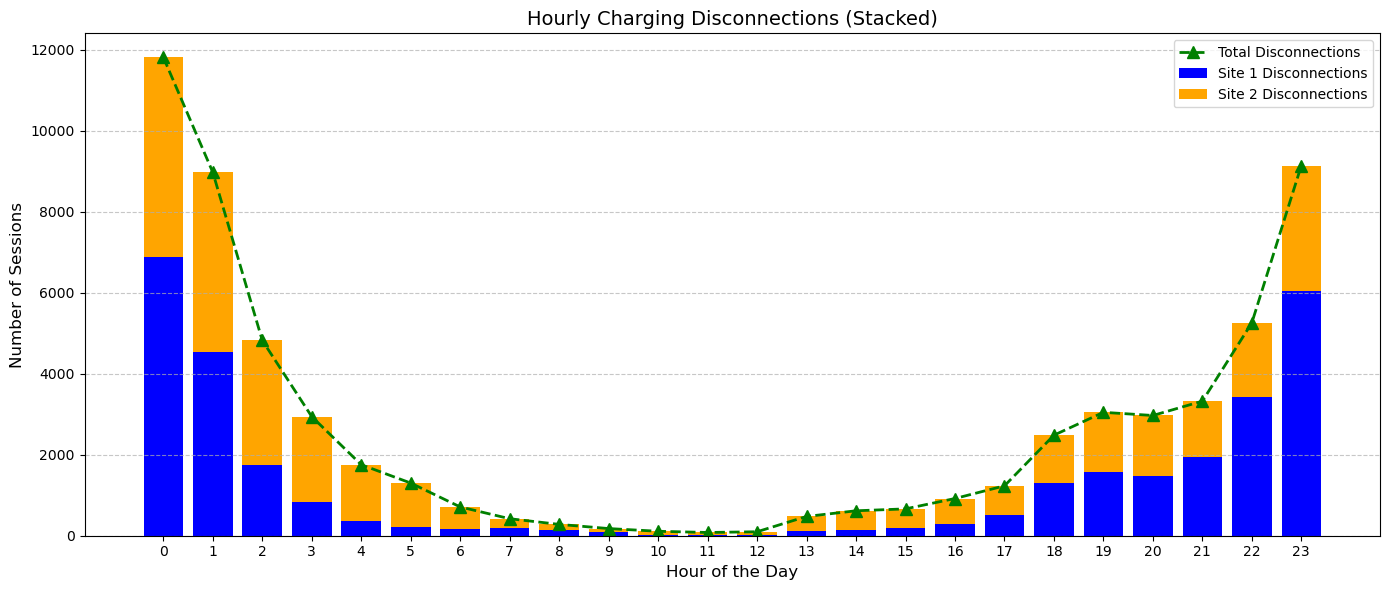

In [15]:
plt.figure(figsize=(14, 6))

# Plot stacked bars for disconnections
plt.bar(hourly_site1_disconnect.index, hourly_site1_disconnect.values, 
        label='Site 1 Disconnections', color='blue')
plt.bar(hourly_site2_disconnect.index, hourly_site2_disconnect.values, 
        bottom=hourly_site1_disconnect.values, 
        label='Site 2 Disconnections', color='orange')

# Add total line (optional)
plt.plot(hourly_total_disconnect.index, hourly_total_disconnect.values, 
         color='green', marker='^', linestyle='--', linewidth=2, markersize=8, 
         label='Total Disconnections')

# Formatting
plt.title('Hourly Charging Disconnections (Stacked)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

# Ensure connectionTime is in datetime format
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

# Extract the weekday from the connection time
charging['weekday'] = charging['connectionTime'].dt.dayofweek

# Filter for sessions that start on weekends (Saturday=5, Sunday=6)
weekend_sessions = charging[charging['weekday'] >= 5]

# Count the number of sessions per site
weekend_sessions_per_site = weekend_sessions.groupby('siteID').size()

# Print the aggregated results
print(weekend_sessions_per_site)



siteID
1     983
2    4988
dtype: int64


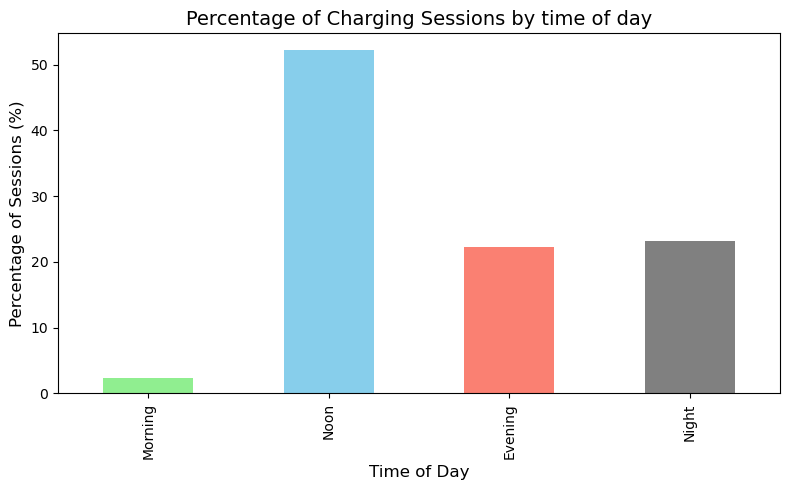

In [17]:
def classify_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

charging['time_of_day'] = charging['connectionTime'].dt.hour.apply(classify_time_of_day)

# Number of charging sessions for each time of day
time_of_day_counts = charging['time_of_day'].value_counts().reindex(['Morning', 'Noon', 'Evening', 'Night'])

# Calculate percentage of each category
time_of_day_percentage = (time_of_day_counts / time_of_day_counts.sum()) * 100

# create bar chart
plt.figure(figsize=(8, 5))  
time_of_day_percentage.plot(kind='bar', color=['lightgreen', 'skyblue', 'salmon', 'gray'])

plt.title('Percentage of Charging Sessions by time of day', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Percentage of Sessions (%)', fontsize=12)
plt.tight_layout()
plt.show()


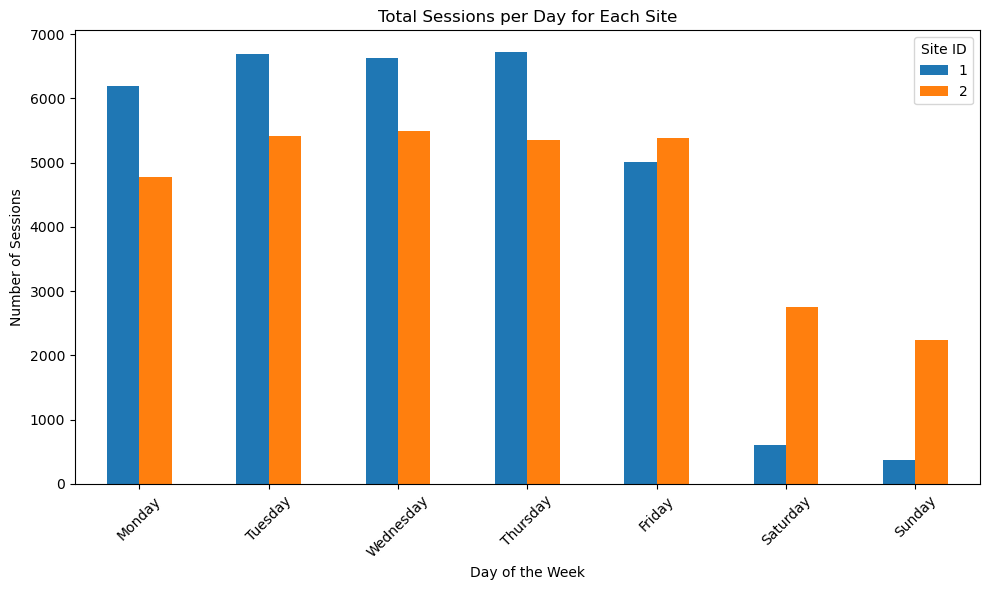

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure connectionTime is in datetime format
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

# Extract the weekday and site information
charging['weekday'] = charging['connectionTime'].dt.dayofweek  # 0=Monday, 6=Sunday

# Group by site and weekday, and count the number of sessions
sessions_per_day_site = charging.groupby(['siteID', 'weekday']).size().reset_index(name='session_count')

# Pivot the data for better visualization
sessions_pivot = sessions_per_day_site.pivot(index='weekday', columns='siteID', values='session_count').fillna(0)

# Plotting
sessions_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Total Sessions per Day for Each Site')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sessions')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()


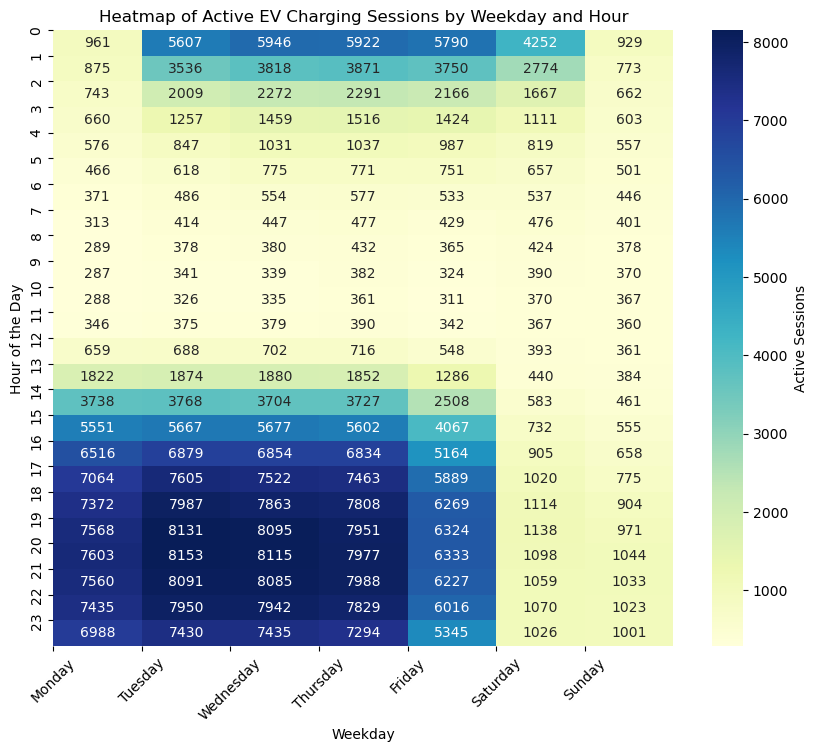

In [19]:
charging['weekday'] = charging['connectionTime'].dt.dayofweek
charging['hour_of_day'] = charging['connectionTime'].dt.hour

# Create a DataFrame of all hours within each session
charging['hourly_range'] = charging.apply(
    lambda row: pd.date_range(
        start=row['connectionTime'].floor('h'),
        end=row['disconnectTime'].ceil('h') - pd.Timedelta(hours=1),
        freq='h'
    ), axis=1
)

# Expand the hourly ranges into individual rows
expanded = charging.explode('hourly_range')

# Extract weekday and hour of day
expanded['weekday'] = expanded['hourly_range'].dt.dayofweek
expanded['hour_of_day'] = expanded['hourly_range'].dt.hour

# Group by weekday and hour_of_day to count active sessions
summary = expanded.groupby(['weekday', 'hour_of_day']).size().reset_index(name='active_sessions')

# Pivot data for heatmap
heatmap_data = summary.pivot(index='hour_of_day', columns='weekday', values='active_sessions').fillna(0)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".0f", cbar_kws={'label': 'Active Sessions'})
plt.title("Heatmap of Active EV Charging Sessions by Weekday and Hour")
plt.xlabel("Weekday")
plt.ylabel("Hour of the Day")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.yticks(ticks=range(0, 24), labels=range(0, 24))
plt.show()

This heatmap shows the active charging sessions in correlation of hour of the day and weekday.
The active sessions are found by finding the sum of sessions
which have already started until this hour and are disconnected after the particular hour.

<h5>Interpretation</h5>

Regardless of the approach, we see that there is a **pattern in daily use**. In the early morning hours the demand is at its lowest and the demand increases as we reach Noon. The **peak time** of demand is the Noon time around 12pm to 6pm and in the evening from 6pm on the demand decreases linearly until the next day on 10am right before noon

<h2> Task 2 a.) - Showing weekly demand

The problem here is that 42% of the sessions start on one day and end in the next day or longer, so it isn't optimal to assign day belonging based on connection time

In [25]:
#count the percentage of sessions that go over multiple days
sessions_spanning_midnight = len(charging[charging['connectionTime'].dt.date != charging['disconnectTime'].dt.date])
percentage_spanning_midnight = (sessions_spanning_midnight / len(charging)) * 100

print(percentage_spanning_midnight)

42.60499182698353


<h4>Approach for showing weekly demand </h4>

The problem here is that some sessions might start at 23:59 and if we would only regard "connectionTime" for day belonging, some sessions which begin at 23:59 are assigned to this day which isn't accurate. 

My proposed soluton: for each row/session, compute the duration (disconnectTime-connectTime) and we assign the session to the day where the **majority of the charging duration** occured

Monday: 10555 sessions
Tuesday: 12094 sessions
Wednesday: 12037 sessions
Thursday: 12162 sessions
Friday: 10593 sessions
Saturday: 3556 sessions
Sunday: 2627 sessions


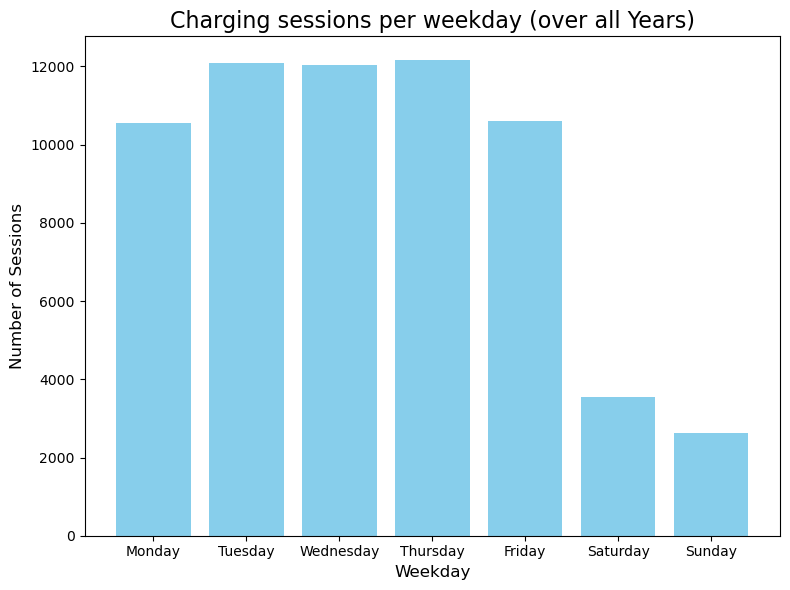

In [27]:
weekday_counts = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    # Calculate duration of particular session
    duration = disconnect_time - connection_time
    
    # Case 1: session is on the same day. if yes, we can stop here
    if connection_time.date() == disconnect_time.date():
        # Add to the weekday of the connection time
        weekday_counts[connection_time.strftime('%A')] += 1
    
    # Case 2: Session spanning multiple days
    else:
        # Split the duration into two parts:  
        # First part is from connetcion time to midnight of the same day
        # Second part is from midnight to disconnect time on the next day
        
        
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday_counts[connection_time.strftime('%A')] += 1
        else:
            weekday_counts[disconnect_time.strftime('%A')] += 1


for day, count in weekday_counts.items():
    print(f"{day}: {count} sessions")


plt.figure(figsize=(8, 6))
plt.bar(weekday_counts.keys(), weekday_counts.values(), color='skyblue')
plt.title('Charging sessions per weekday (over all Years)', fontsize=16)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()


<h1>Idea: Create boxplot to show average weekday demand. -> charging session per weekday and compute mean/average </h1>

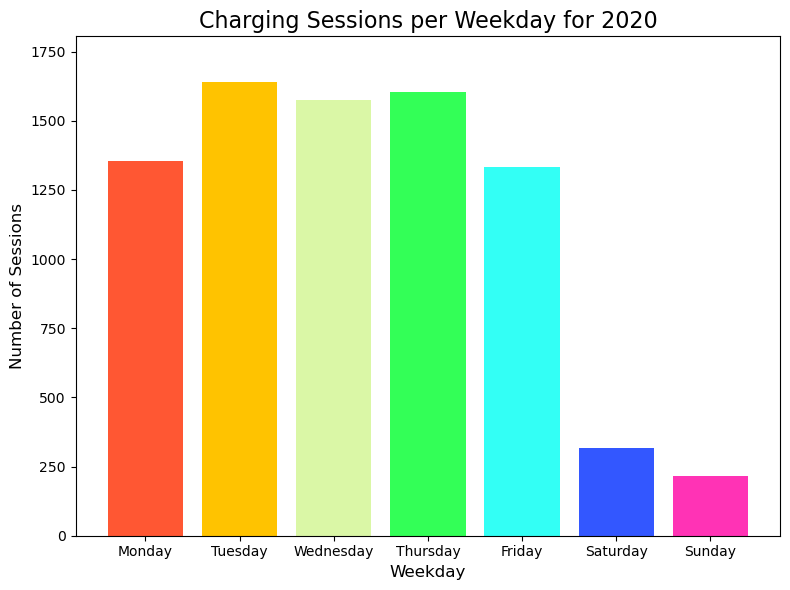

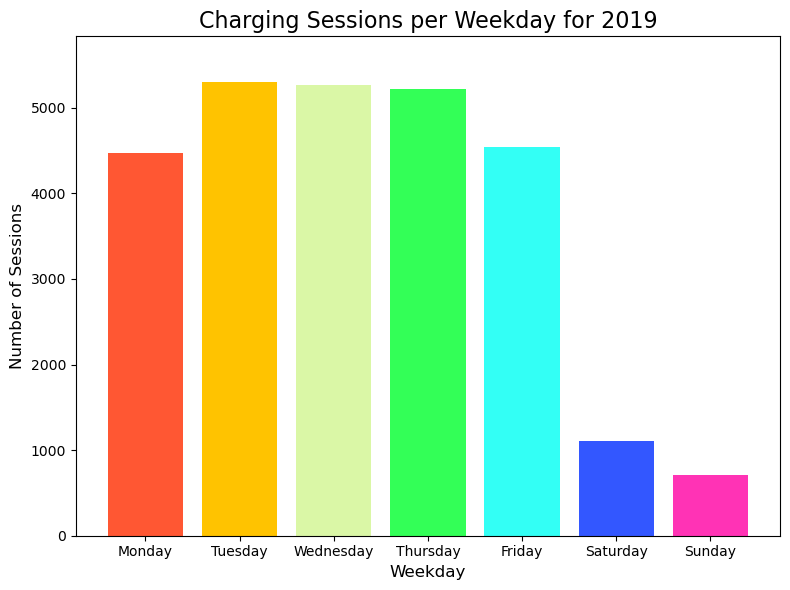

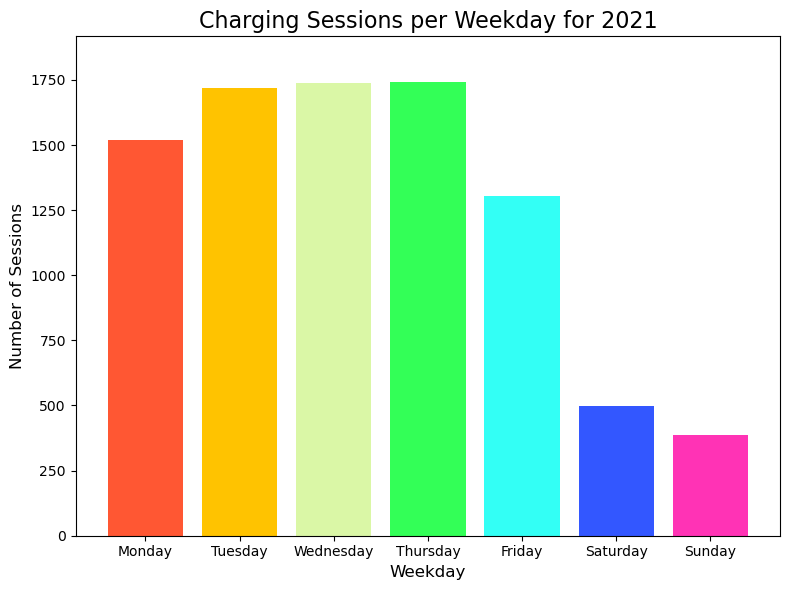

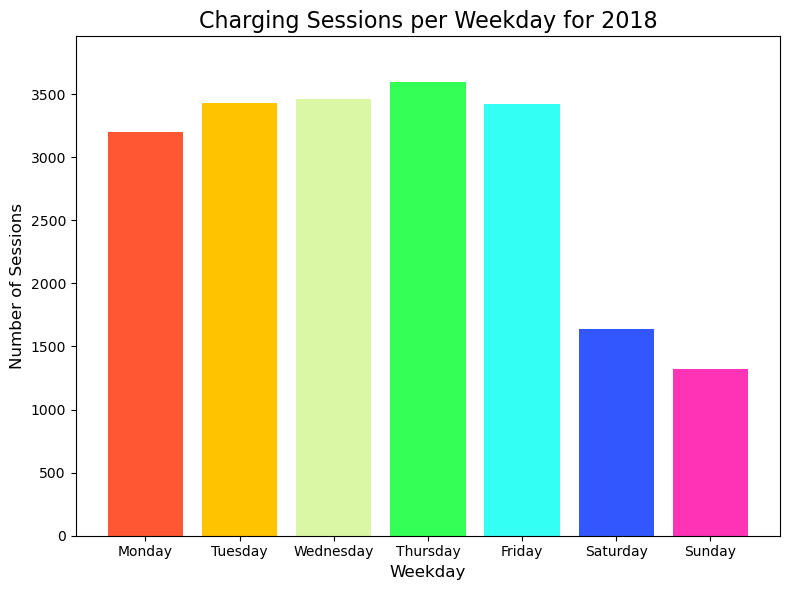

In [29]:
#grouping the weeks by year (just for testing). here wo would have to normalize

yearly_weekday_counts = {}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    duration = disconnect_time - connection_time
    
    year = connection_time.year
    
    if year not in yearly_weekday_counts:
        yearly_weekday_counts[year] = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}
    
    if connection_time.date() == disconnect_time.date():
        weekday = connection_time.strftime('%A')
        yearly_weekday_counts[year][weekday] += 1
    
    else:
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday = connection_time.strftime('%A')
        else:
            weekday = disconnect_time.strftime('%A')
        
        yearly_weekday_counts[year][weekday] += 1

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

colors = ['#FF5733', '#FFC300', '#DAF7A6', '#33FF57', '#33FFF5', '#3357FF', '#FF33B5']


for year, counts in yearly_weekday_counts.items():
    plt.figure(figsize=(8, 6))
    plt.bar(weekdays, counts.values(), color=colors)    
    plt.title(f'Charging Sessions per Weekday for {year}', fontsize=16)
    plt.xlabel('Weekday', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)  
    plt.ylim(0, max(max(counts.values()) * 1.1, 25))  
    
    plt.tight_layout()
    plt.show()




Regardless of the which approach, we can clearly see that the **peak days are tuesday, wednesday and thursday.** On the weekend, demand isn't that hight. Intuitively, this makes sense as most people would use their E-Cars on weekdays.

**Interestingly, the proportion of sessions in year 2018 on the weekend were higher than in the next years**

<h1> Idea: Show site demand per year </h1>

<h2> Task 2 a.) - Showing season patterns

Proposed approaches: 
1. Divide year in summer, spring, winter and autumn and show numbers (for each year)
2. Show monthly number of sessions over the year
3. Show the number of sessions over the years(i.e. for each year)

Try approach 1 and 2


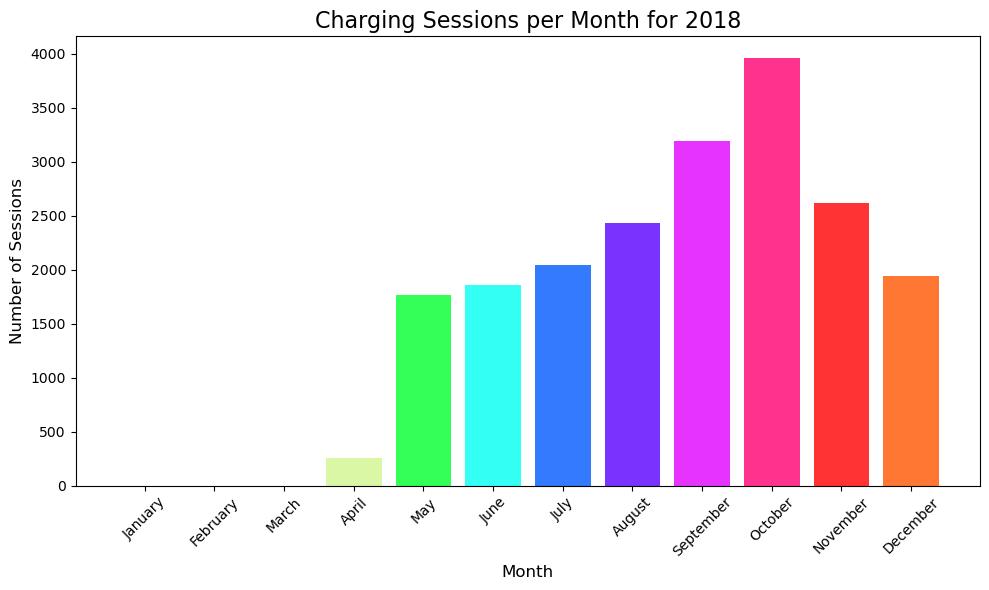

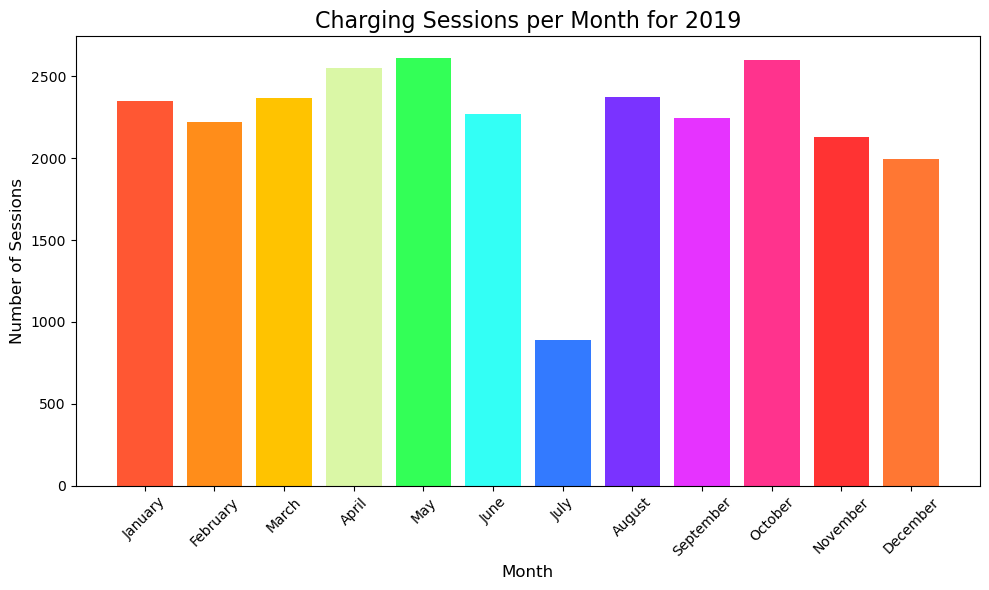

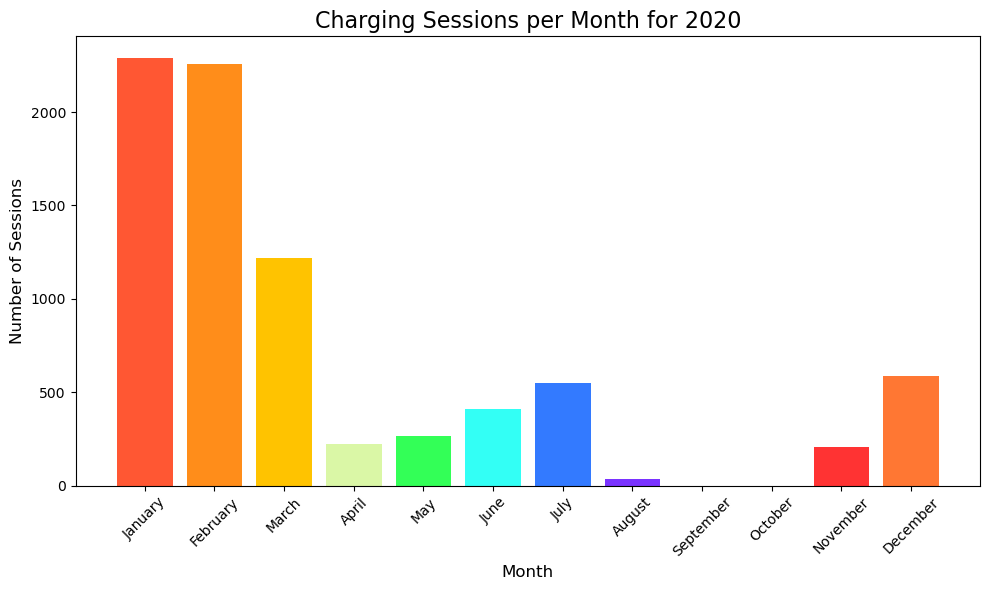

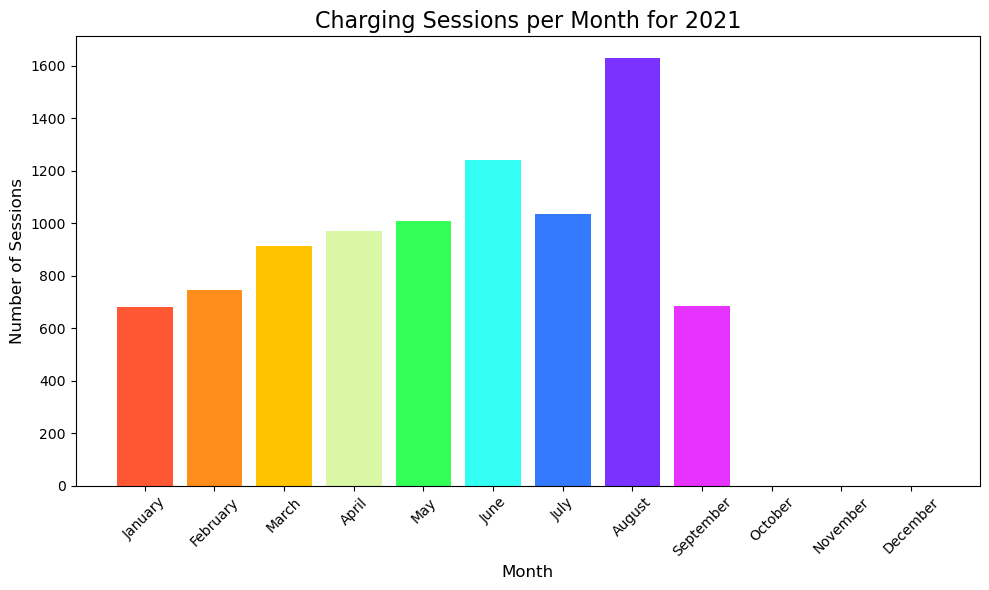

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar


# Approach 1
''''
def get_season(date):
    if (date.month == 12 and date.day >= 21) or (date.month <= 3 and date.month >= 1):
        return 'Winter'
    elif 3 <= date.month <= 5:
        return 'Spring'
    elif 6 <= date.month <= 8:
        return 'Summer'
    elif 9 <= date.month <= 11:
        return 'Fall'

charging['season'] = charging['connectionTime'].apply(get_season)
charging['year'] = charging['connectionTime'].dt.year
seasonal_trends = charging.groupby(['year', 'season']).size().unstack(fill_value=0)
seasonal_trends.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Seasonal charging sessions trends over the years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
'''







#approach 2
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

charging['year'] = charging['connectionTime'].dt.year
charging['month'] = charging['connectionTime'].dt.month

yearly_monthly_counts = charging.groupby(['year', 'month']).size().unstack(fill_value=0)

month_colors = [
    '#FF5733', '#FF8D1A', '#FFC300', '#DAF7A6', '#33FF57',
    '#33FFF5', '#337AFF', '#7A33FF', '#E633FF', '#FF338D',
    '#FF3333', '#FF7733'
]

for year, counts in yearly_monthly_counts.iterrows():
    plt.figure(figsize=(10, 6))
    months = [calendar.month_name[i] for i in range(1, 13)]
    plt.bar(months, counts, color=month_colors)
    
    plt.title(f'Charging Sessions per Month for {year}', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [35]:
earliest_index = charging['connectionTime'].idxmin()
earliest_row = charging.loc[earliest_index]

earliest_row

id                                                        5bc90cb9f9af8b0d7fe77cd2
connectionTime                                           2018-04-25 11:08:04+00:00
disconnectTime                                           2018-04-25 13:20:10+00:00
doneChargingTime                                         2018-04-25 13:20:10+00:00
kWhDelivered                                                                 7.932
sessionID                                   2_39_78_362_2018-04-25 11:08:04.400812
siteID                                                                           2
spaceID                                                                     CA-496
stationID                                                              2-39-78-362
userID                                                                           0
userInputs_WhPerMile                                                         469.0
userInputs_kWhRequested                                                      14.07
user

In [36]:
latest_index = charging['connectionTime'].idxmax()
latest_row = charging.loc[latest_index]

latest_row

id                                                        6155053bf9af8b76960e16d1
connectionTime                                           2021-09-14 05:43:39+00:00
disconnectTime                                           2021-09-14 14:46:28+00:00
doneChargingTime                                         2021-09-14 14:46:22+00:00
kWhDelivered                                                                53.937
sessionID                                   1_1_178_817_2021-09-14 05:43:27.354300
siteID                                                                           1
spaceID                                                                    AG-1F09
stationID                                                              1-1-178-817
userID                                                                         500
userInputs_WhPerMile                                                         350.0
userInputs_kWhRequested                                                       17.5
user

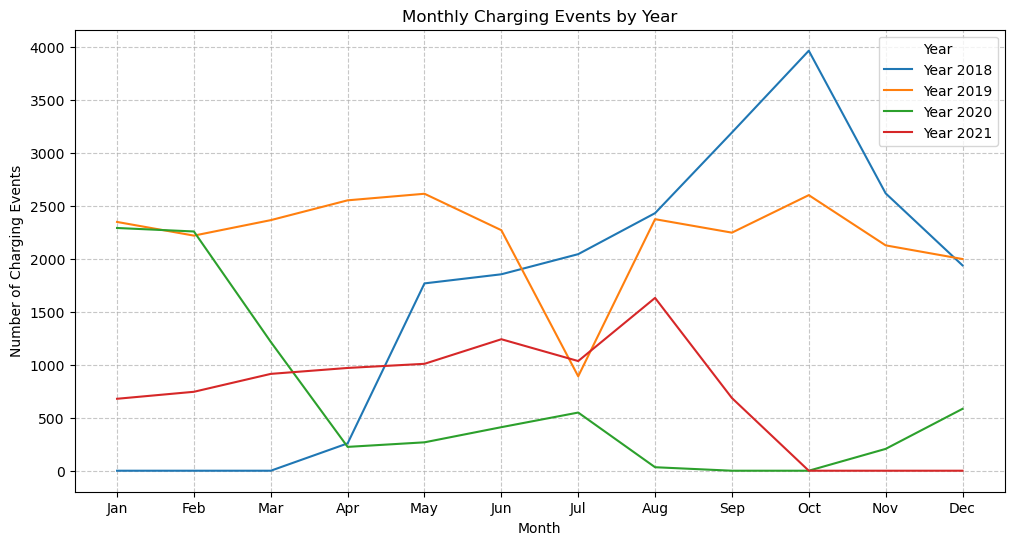

In [37]:
charging['year'] = charging['connectionTime'].dt.year
charging['month'] = charging['connectionTime'].dt.month

yearly_monthly_counts = charging.groupby(['year', 'month']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Charging Events by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

C:\Users\Willi\AppData\Local\Temp\ipykernel_12772\1003240197.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  daily_sessions['year_month'] = daily_sessions['connectionTime'].dt.to_period('M')


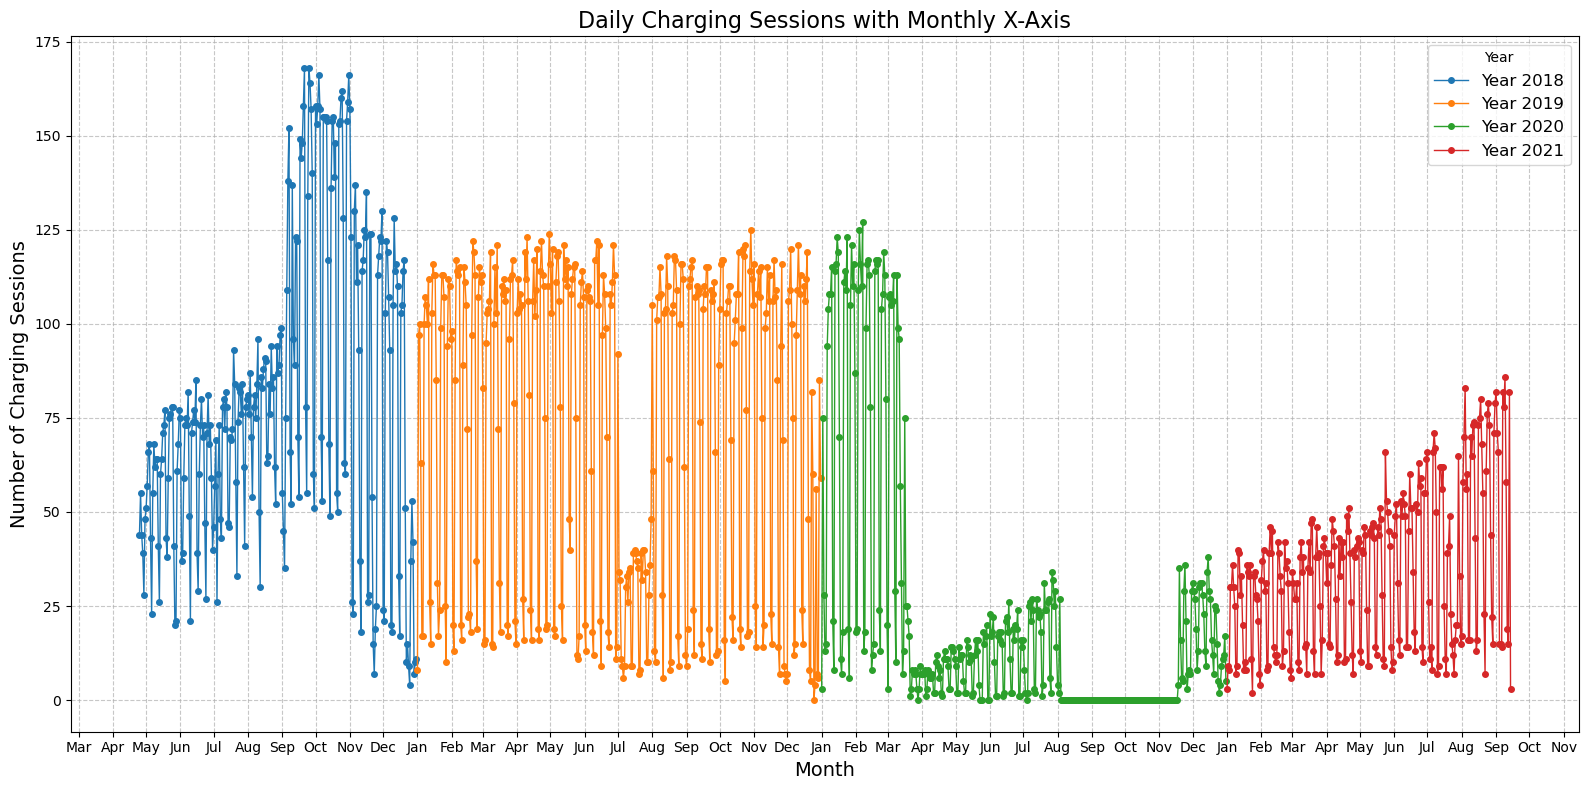

In [38]:
# Ensure 'connectionTime' is in datetime format
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

# Resample the data to daily frequency and count the number of sessions per day
daily_sessions = charging.resample('D', on='connectionTime').size().reset_index(name='sessions')

# Extract year and month from the date
daily_sessions['year'] = daily_sessions['connectionTime'].dt.year
daily_sessions['month'] = daily_sessions['connectionTime'].dt.month

# Create a combined 'year-month' column for grouping
daily_sessions['year_month'] = daily_sessions['connectionTime'].dt.to_period('M')

# Plot the data
plt.figure(figsize=(16, 8))

# Iterate over each year and plot the daily sessions
for year in daily_sessions['year'].unique():
    # Filter data for the current year
    yearly_data = daily_sessions[daily_sessions['year'] == year]
    
    # Plot the daily sessions for the year
    plt.plot(yearly_data['connectionTime'], yearly_data['sessions'], label=f"Year {year}", marker='o', markersize=4, linestyle='-', linewidth=1)

# Customize the x-axis to show months
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  # Format as month abbreviation

# Add labels, title, and legend
plt.title("Daily Charging Sessions with Monthly X-Axis", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Charging Sessions", fontsize=14)
plt.legend(title="Year", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

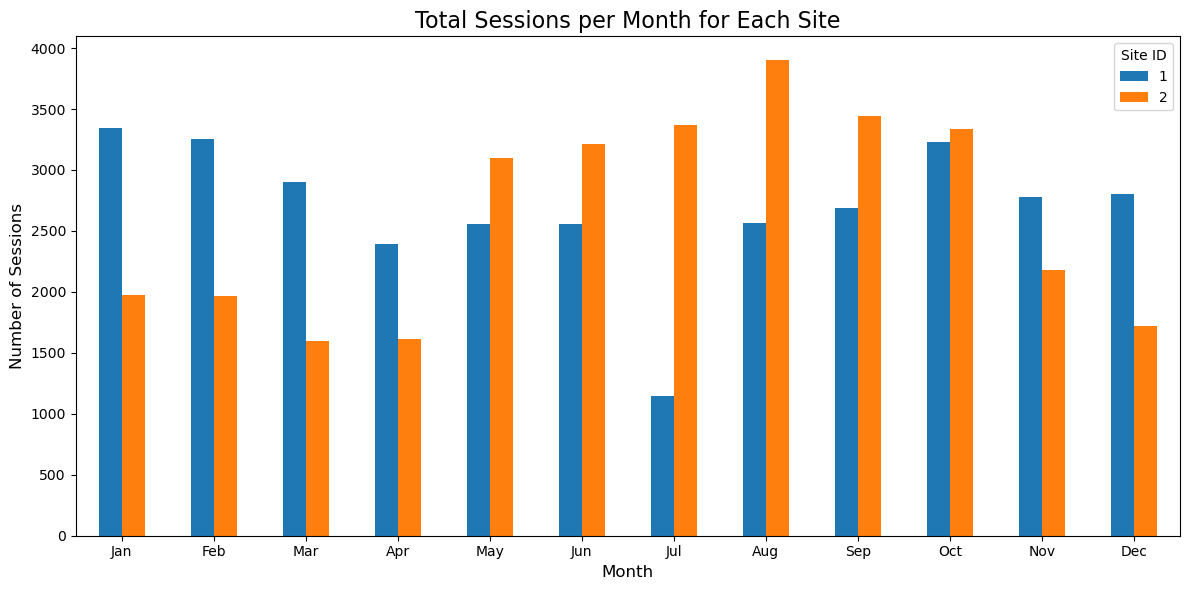

In [39]:
# Extract the month and site information
charging['month'] = charging['connectionTime'].dt.month  # 1=January, 12=December

# Group by site and month, and count the number of sessions
sessions_per_month_site = charging.groupby(['siteID', 'month']).size().reset_index(name='session_count')

# Pivot the data for better visualization
sessions_pivot = sessions_per_month_site.pivot(index='month', columns='siteID', values='session_count').fillna(0)

# Plotting
sessions_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Total Sessions per Month for Each Site', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()

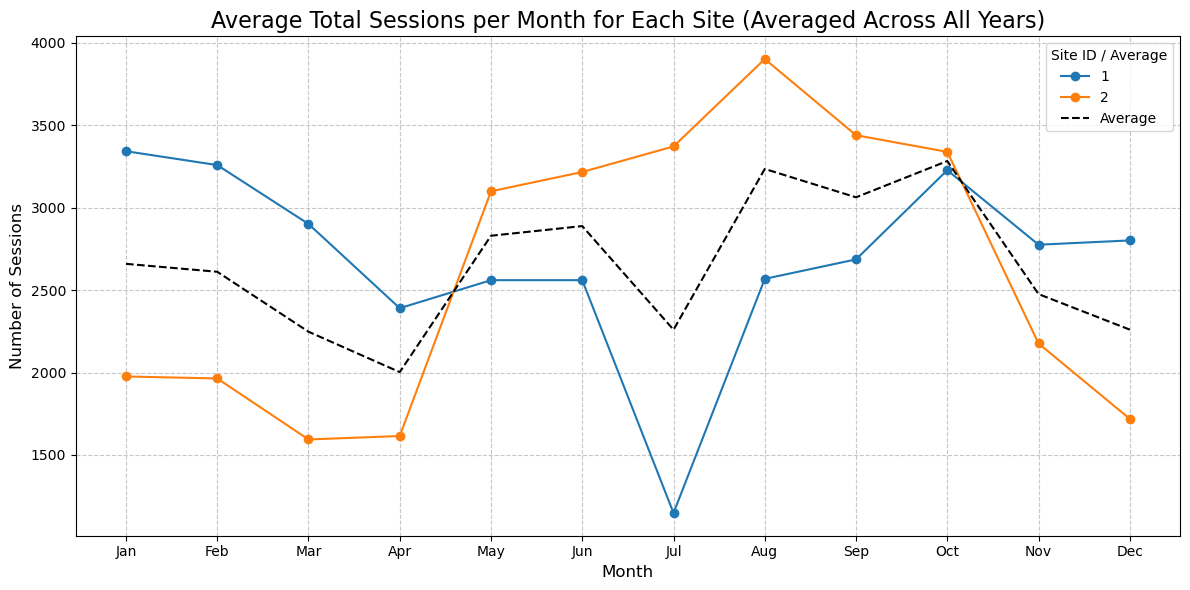

In [40]:
# Extract the month and site information
charging['month'] = charging['connectionTime'].dt.month  # 1=January, 12=December

# Group by site and month, and count the number of sessions
sessions_per_month_site = charging.groupby(['siteID', 'month']).size().reset_index(name='session_count')

# Pivot the data for better visualization
# sessions_pivot = sessions_per_month_site.pivot(index='month', columns='siteID', values='session_count').fillna(0)

# Calculate the average of the two sites for each month
sessions_pivot['Average'] = sessions_pivot.mean(axis=1)

# Plotting
ax = sessions_pivot.drop(columns='Average').plot(kind='line', figsize=(12, 6), marker='o')  # Plot individual sites
sessions_pivot['Average'].plot(kind='line', linestyle='--', color='black', ax=ax, label='Average')  # Plot average as a black dashed line

plt.title('Average Total Sessions per Month for Each Site (Averaged Across All Years)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.legend(title='Site ID / Average')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

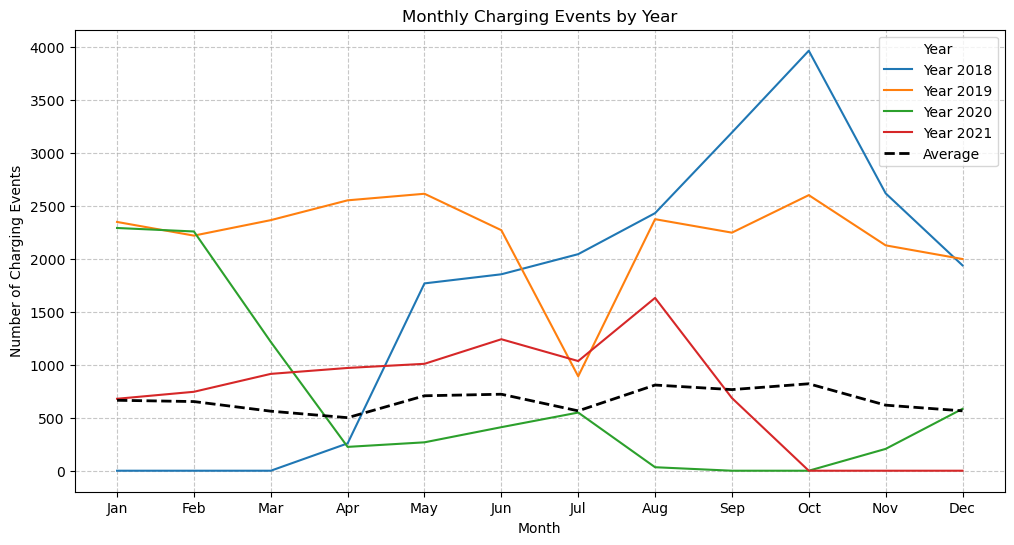

In [41]:
# Group by site, year, and month, and count the number of sessions
site_yearly_monthly_counts = charging.groupby(['siteID', 'year', 'month']).size().unstack(fill_value=0)

# Calculate the average across years for each site
average_counts_by_site = site_yearly_monthly_counts.groupby(level='siteID').mean()

# Calculate the overall average across all sites
average_counts = average_counts_by_site.mean(axis=0)

# Plotting
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Plot the average line
plt.plot(average_counts.index, average_counts.values, label="Average", color='black', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.title("Monthly Charging Events by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

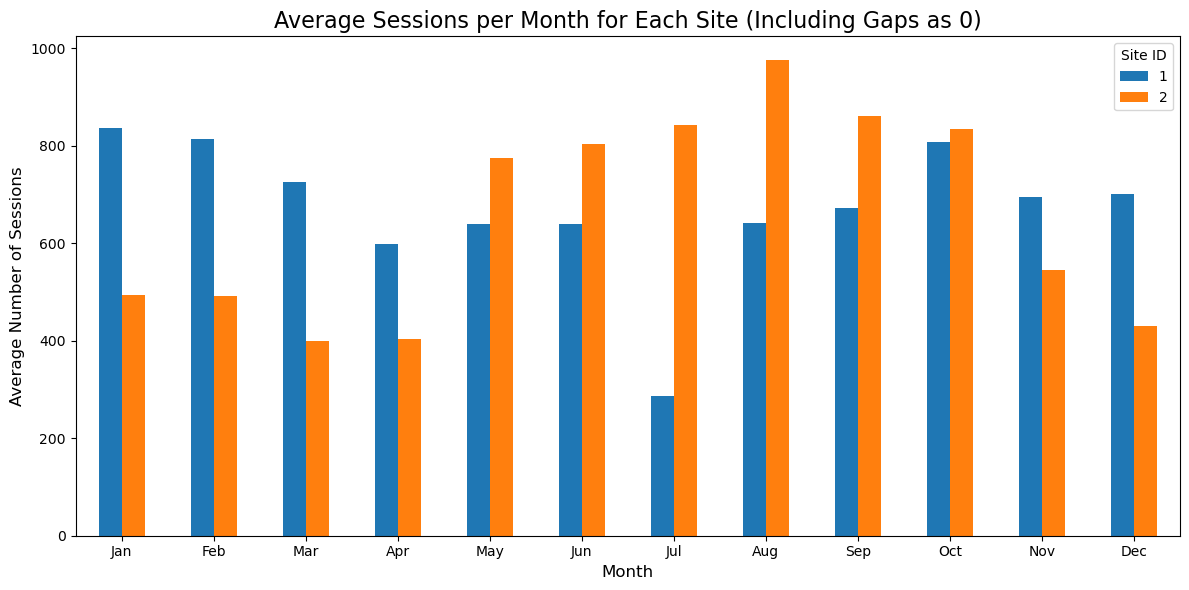

In [42]:
from itertools import product

# Ensure connectionTime is in datetime format
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

# Extract the month and year
charging['month'] = charging['connectionTime'].dt.month  # 1=January, 12=December
charging['year'] = charging['connectionTime'].dt.year

# Group by site, year, and month, and count the number of sessions
sessions_per_month_site = charging.groupby(['siteID', 'year', 'month']).size().reset_index(name='session_count')

# Create a complete grid of all combinations of siteID, year, and month
all_sites = charging['siteID'].unique()
all_years = charging['year'].unique()
all_months = range(1, 13)  # 1 to 12 for months

# Generate all possible combinations of siteID, year, and month
complete_grid = pd.DataFrame(list(product(all_sites, all_years, all_months)), columns=['siteID', 'year', 'month'])

# Merge the complete grid with the session counts
sessions_complete = pd.merge(complete_grid, sessions_per_month_site, on=['siteID', 'year', 'month'], how='left')

# Fill missing session counts with 0
sessions_complete['session_count'] = sessions_complete['session_count'].fillna(0)

# Calculate the average number of sessions per month for each site
average_sessions_per_month = sessions_complete.groupby(['siteID', 'month'])['session_count'].mean().reset_index()

# Pivot the data for better visualization
average_sessions_pivot = average_sessions_per_month.pivot(index='month', columns='siteID', values='session_count')

# Plotting
average_sessions_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Average Sessions per Month for Each Site (Including Gaps as 0)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Number of Sessions', fontsize=12)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()

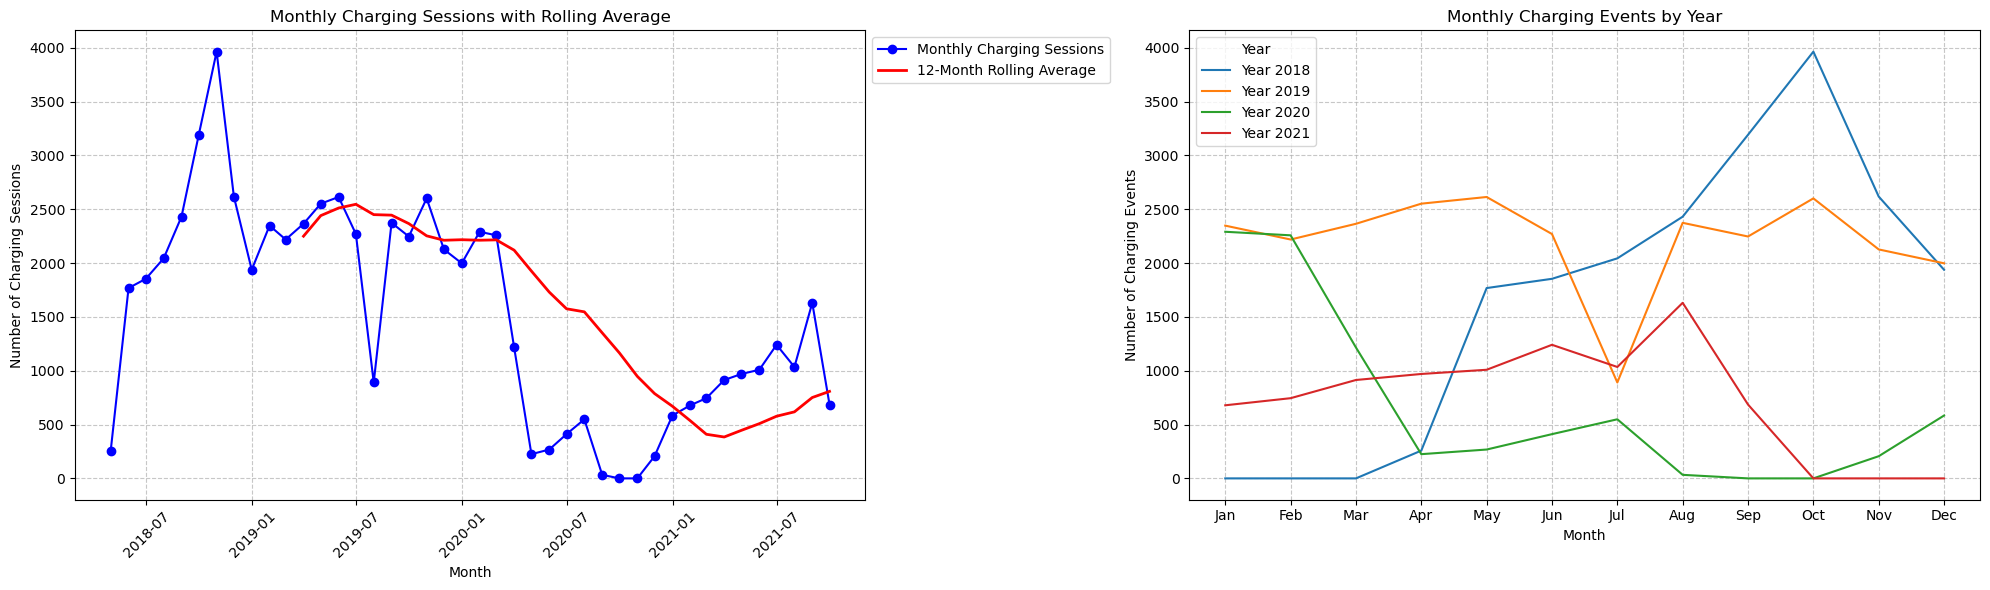

In [43]:
import matplotlib.dates as mdates

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# --- First Plot: Monthly Charging Sessions with Rolling Average ---
# Resample the charging sessions by month and count the number of sessions per month
monthly_charging = charging.resample('ME', on='connectionTime').size()

# Convert to a DataFrame for easier manipulation
monthly_charging = monthly_charging.to_frame(name='sessions')

# Plot the monthly charging sessions
ax1.plot(monthly_charging.index, monthly_charging['sessions'], label="Monthly Charging Sessions", color='blue', marker='o')

# Calculate a 12-month rolling average
rolling_avg = monthly_charging['sessions'].rolling(window=12).mean()

# Plot the rolling average
ax1.plot(rolling_avg.index, rolling_avg.values, label="12-Month Rolling Average", color='red', linewidth=2)

# Add labels, title, and legend
ax1.set_title("Monthly Charging Sessions with Rolling Average")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Charging Sessions")
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
ax1.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show month and year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45)

# --- Second Plot: Monthly Charging Events by Year ---
charging['year'] = charging['connectionTime'].dt.year
charging['month'] = charging['connectionTime'].dt.month

yearly_monthly_counts = charging.groupby(['year', 'month']).size().unstack(fill_value=0)

for year in yearly_monthly_counts.index:
    ax2.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
ax2.set_title("Monthly Charging Events by Year")
ax2.set_xlabel("Month")
ax2.set_ylabel("Number of Charging Events")
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.legend(title="Year")
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Looks exactly the same as with total amount, so we can just use the total amount plot

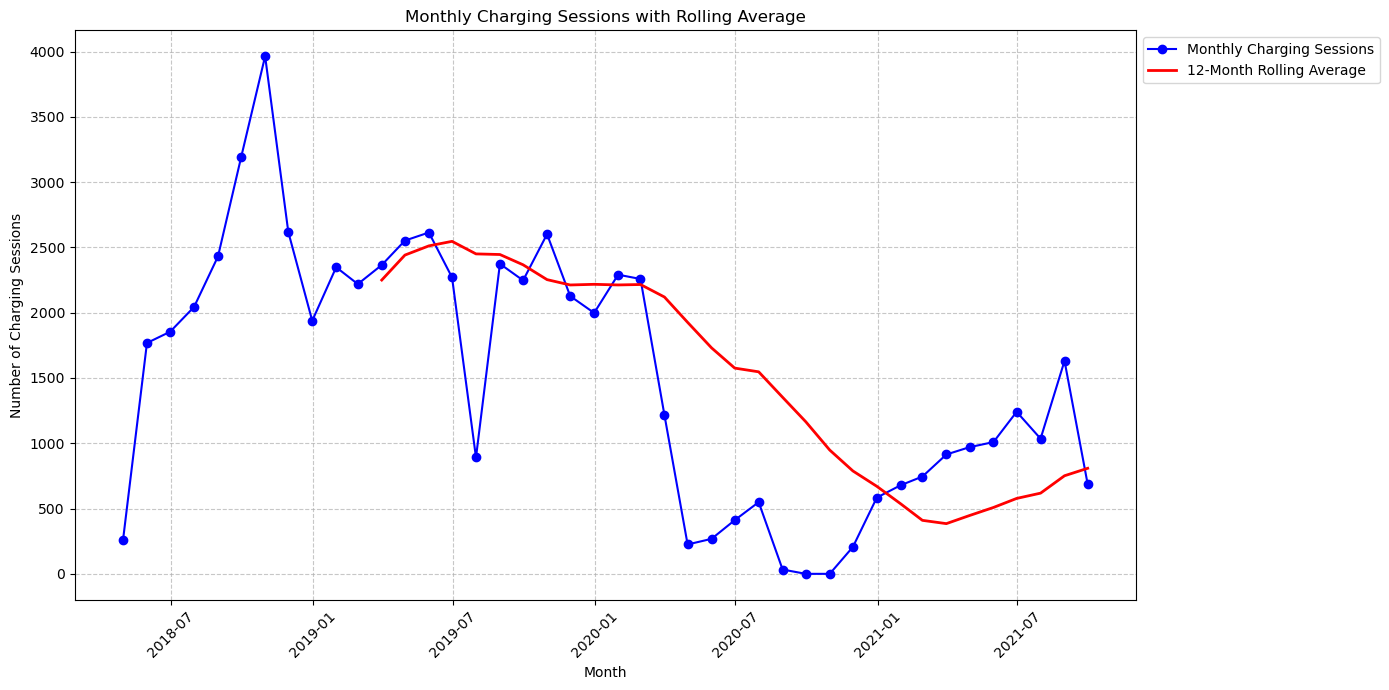

In [45]:
import matplotlib.dates as mdates

# Resample the charging sessions by month and count the number of sessions per month
monthly_charging = charging.resample('ME', on='connectionTime').size()

# Convert to a DataFrame for easier manipulation
monthly_charging = monthly_charging.to_frame(name='sessions')

# Plot the monthly charging sessions
plt.figure(figsize=(14, 7))
plt.plot(monthly_charging.index, monthly_charging['sessions'], label="Monthly Charging Sessions", color='blue', marker='o')

# Calculate a 12-month rolling average
rolling_avg = monthly_charging['sessions'].rolling(window=12).mean()

# Plot the rolling average
plt.plot(rolling_avg.index, rolling_avg.values, label="12-Month Rolling Average", color='red', linewidth=2)

# Add labels, title, and legend
plt.title("Monthly Charging Sessions with Rolling Average")
plt.xlabel("Month")
plt.ylabel("Number of Charging Sessions")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show month and year
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

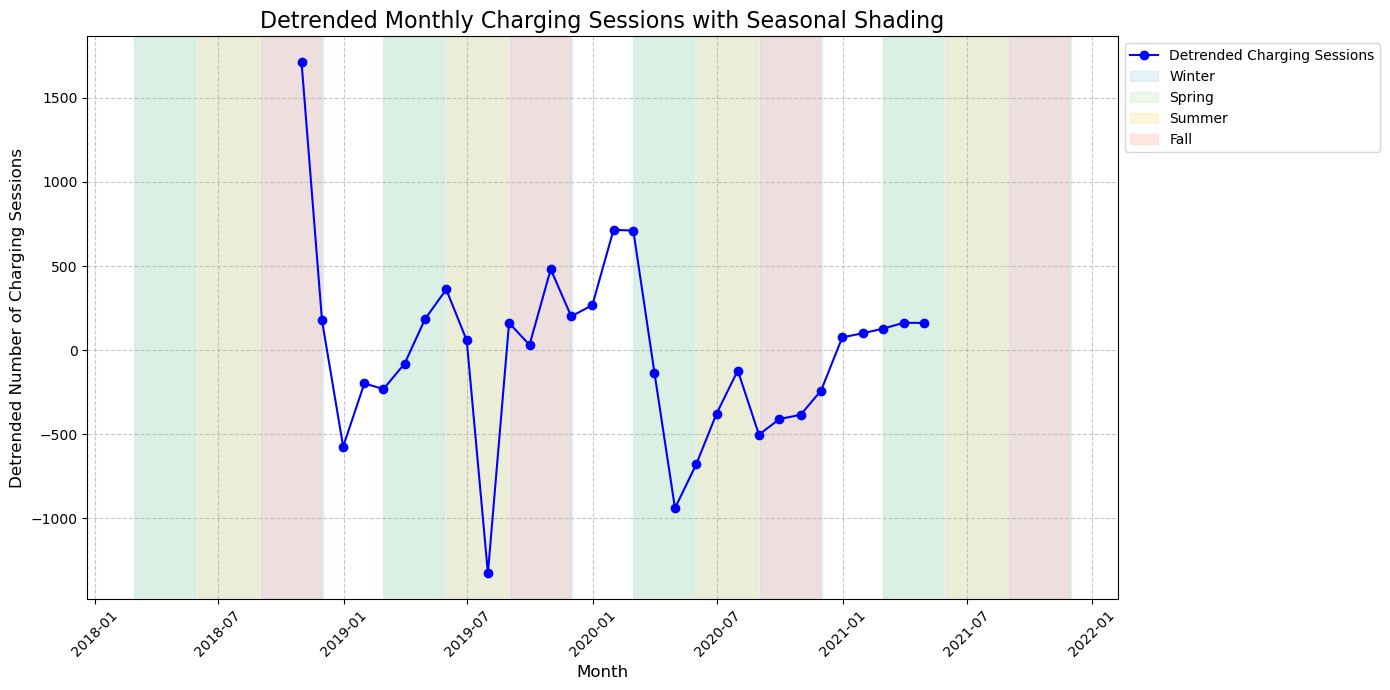

In [46]:
# Calculate a 12-month rolling average to represent the trend
rolling_avg = monthly_charging['sessions'].rolling(window=12, center=True).mean()

# Detrend the data by subtracting the rolling average
detrended_sessions = monthly_charging['sessions'] - rolling_avg

# Plot the detrended data
plt.figure(figsize=(14, 7))
plt.plot(detrended_sessions.index, detrended_sessions, label="Detrended Charging Sessions", color='blue', marker='o')

# Add seasonal shading with clear colors
seasons = {
    'Winter': {'months': [12, 1, 2], 'color': '#A6D8E7', 'alpha': 0.3},  # Light blue
    'Spring': {'months': [3, 4, 5], 'color': '#C6EBBE', 'alpha': 0.3},  # Light green
    'Summer': {'months': [6, 7, 8], 'color': '#FFE08C', 'alpha': 0.3},  # Light yellow
    'Fall': {'months': [9, 10, 11], 'color': '#FFB3A6', 'alpha': 0.3}   # Light coral
}

# To avoid duplicate labels in the legend
added_labels = set()

for season, props in seasons.items():
    for year in monthly_charging.index.year.unique():
        start_date = f"{year}-{props['months'][0]:02d}-01"
        end_date = f"{year}-{props['months'][-1]:02d}-28"  # Approximate end of the season
        if season not in added_labels:
            plt.axvspan(start_date, end_date, color=props['color'], alpha=props['alpha'], label=f'{season}')
            added_labels.add(season)
        else:
            plt.axvspan(start_date, end_date, color=props['color'], alpha=props['alpha'])

# Add labels, title, and legend
plt.title("Detrended Monthly Charging Sessions with Seasonal Shading", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Detrended Number of Charging Sessions", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show month and year
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

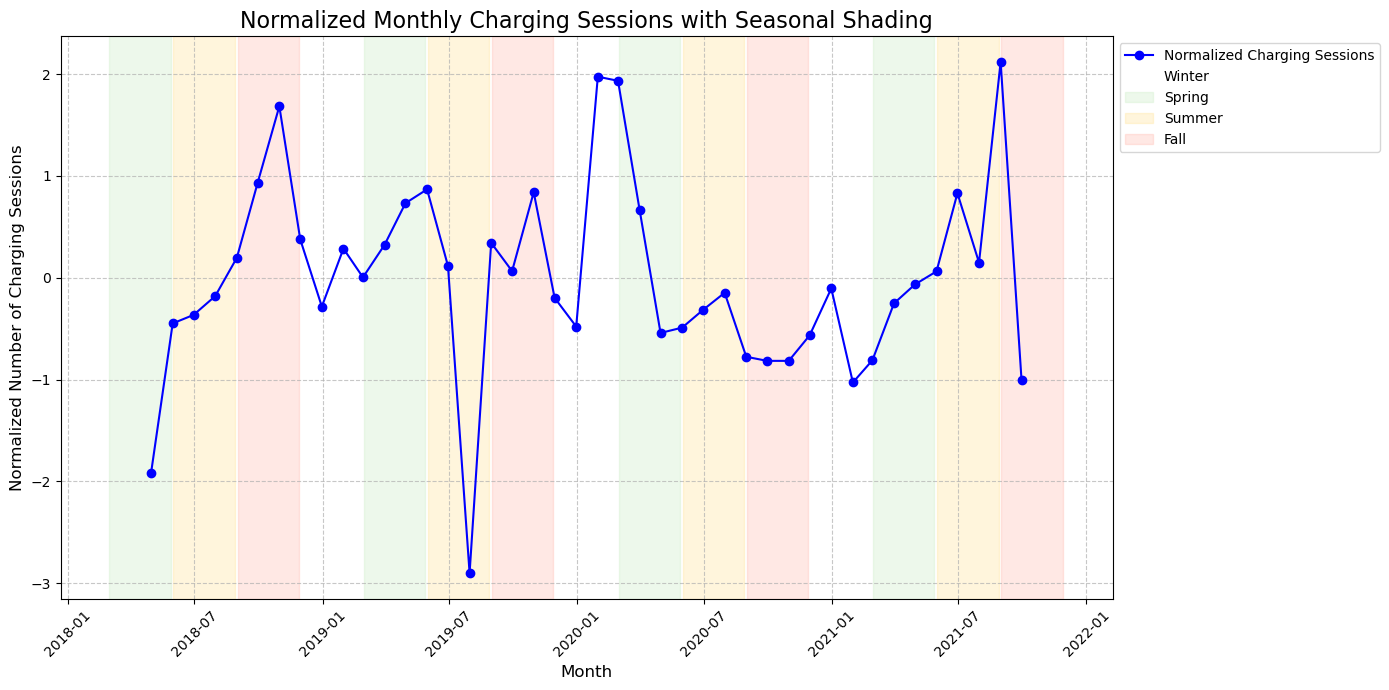

In [47]:
# Normalize the data by year (subtract the mean and divide by the standard deviation for each year)
monthly_charging['year'] = monthly_charging.index.year
normalized_sessions = monthly_charging.groupby('year')['sessions'].transform(lambda x: (x - x.mean()) / x.std())

# Plot the normalized data
plt.figure(figsize=(14, 7))
plt.plot(monthly_charging.index, normalized_sessions, label="Normalized Charging Sessions", color='blue', marker='o')

# Add seasonal shading with clear colors
seasons = {
    'Winter': {'months': [12, 1, 2], 'color': '#FFFFFF', 'alpha': 0.3},  # White
    'Spring': {'months': [3, 4, 5], 'color': '#C6EBBE', 'alpha': 0.3},  # Light green
    'Summer': {'months': [6, 7, 8], 'color': '#FFE08C', 'alpha': 0.3},  # Light yellow
    'Fall': {'months': [9, 10, 11], 'color': '#FFB3A6', 'alpha': 0.3}   # Light coral
}

# To avoid duplicate labels in the legend
added_labels = set()

for season, props in seasons.items():
    for year in monthly_charging.index.year.unique():
        start_date = f"{year}-{props['months'][0]:02d}-01"
        end_date = f"{year}-{props['months'][-1]:02d}-28"  # Approximate end of the season
        if season not in added_labels:
            plt.axvspan(start_date, end_date, color=props['color'], alpha=props['alpha'], label=f'{season}')
            added_labels.add(season)
        else:
            plt.axvspan(start_date, end_date, color=props['color'], alpha=props['alpha'])

# Add labels, title, and legend
plt.title("Normalized Monthly Charging Sessions with Seasonal Shading", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Normalized Number of Charging Sessions", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show month and year
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

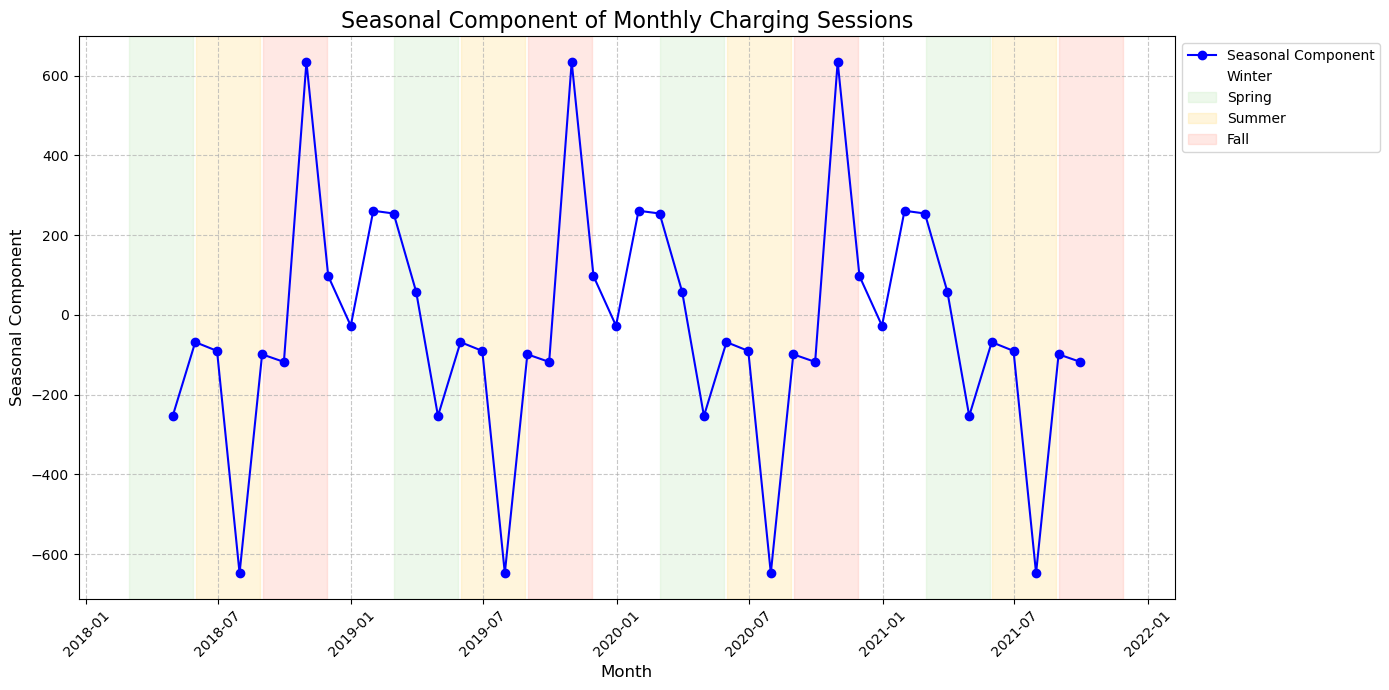

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_charging['sessions'], model='additive', period=12)

# Plot the seasonal component
plt.figure(figsize=(14, 7))
plt.plot(decomposition.seasonal.index, decomposition.seasonal, label="Seasonal Component", color='blue', marker='o')

# Add seasonal shading with clear colors
seasons = {
    'Winter': {'months': [12, 1, 2], 'color': '#FFFFFF', 'alpha': 0.3},  # White
    'Spring': {'months': [3, 4, 5], 'color': '#C6EBBE', 'alpha': 0.3},  # Light green
    'Summer': {'months': [6, 7, 8], 'color': '#FFE08C', 'alpha': 0.3},  # Light yellow
    'Fall': {'months': [9, 10, 11], 'color': '#FFB3A6', 'alpha': 0.3}   # Light coral
}

# To avoid duplicate labels in the legend
added_labels = set()

for season, props in seasons.items():
    for year in monthly_charging.index.year.unique():
        start_date = f"{year}-{props['months'][0]:02d}-01"
        end_date = f"{year}-{props['months'][-1]:02d}-28"  # Approximate end of the season
        if season not in added_labels:
            plt.axvspan(start_date, end_date, color=props['color'], alpha=props['alpha'], label=f'{season}')
            added_labels.add(season)
        else:
            plt.axvspan(start_date, end_date, color=props['color'], alpha=props['alpha'])

# Add labels, title, and legend
plt.title("Seasonal Component of Monthly Charging Sessions", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Seasonal Component", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show month and year
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

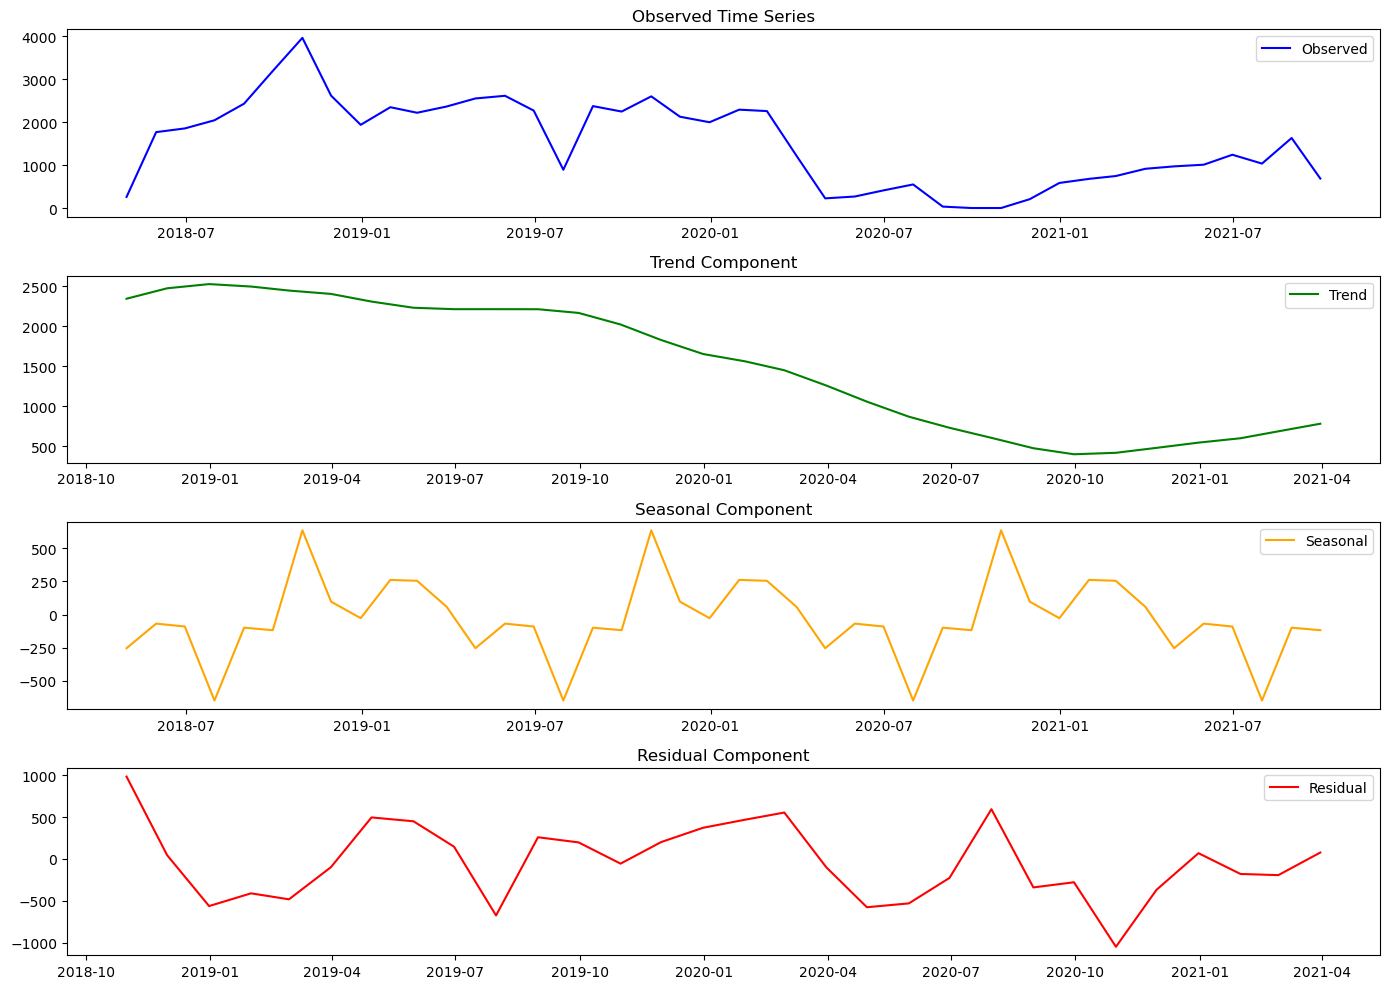

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_charging['sessions'], model='additive', period=12)

# Plot the components
plt.figure(figsize=(14, 10))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label="Observed", color='blue')
plt.title("Observed Time Series")
plt.legend()

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color='green')
plt.title("Trend Component")
plt.legend()

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonal", color='orange')
plt.title("Seasonal Component")
plt.legend()

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual", color='red')
plt.title("Residual Component")
plt.legend()

plt.tight_layout()
plt.show()

# doneChargingTime vs disconnectTime

In [51]:
charging['idle_time_minutes'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 60
(charging['idle_time_minutes'] < 0).any()

False

In [52]:
negative_idle_sessions = charging[charging['idle_time_minutes'] < 0]
negative_idle_sessions

Empty DataFrame
Columns: [id, connectionTime, disconnectTime, doneChargingTime, kWhDelivered, sessionID, siteID, spaceID, stationID, userID, userInputs_WhPerMile, userInputs_kWhRequested, userInputs_milesRequested, userInputs_minutesAvailable, userInputs_modifiedAt, userInputs_paymentRequired, userInputs_requestedDeparture, done_after_disconnect, connectionDay, disconnectionDay, date_matches, hour_of_day, connection_hour, disconnection_hour, weekday, time_of_day, hourly_range, year, month, idle_time_minutes]
Index: []

[0 rows x 30 columns]

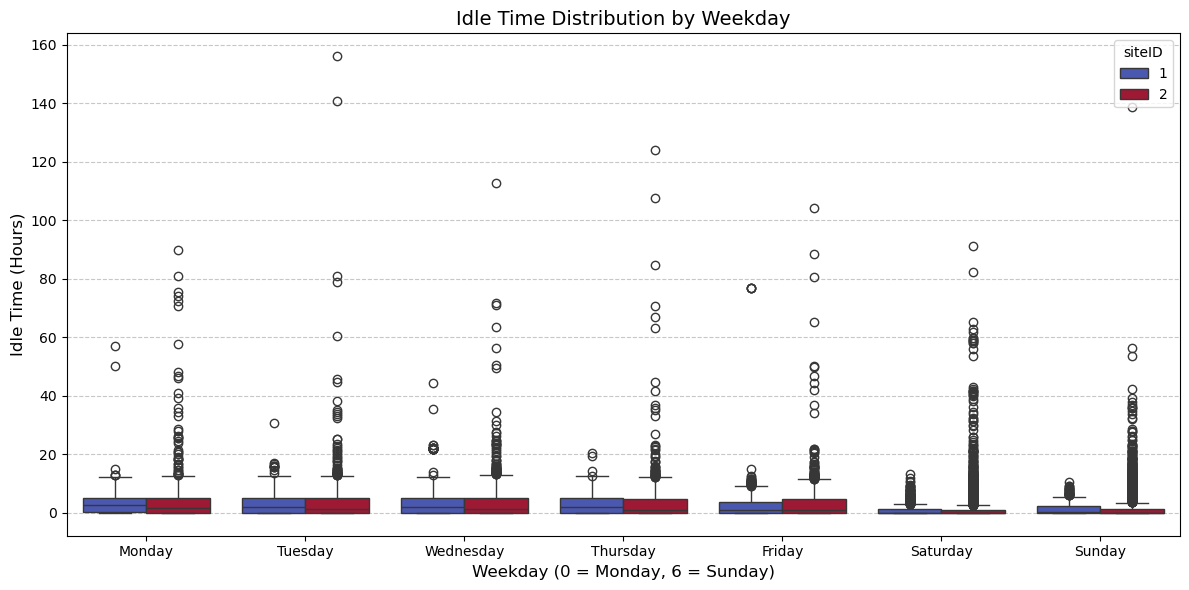

In [53]:
# Add a column for the weekday (0 = Monday, 6 = Sunday)
charging['weekday'] = charging['doneChargingTime'].dt.dayofweek

# Calculate idle time (in minutes)
charging['idle_time_minutes'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 60
charging['idle_time_hours'] = charging['idle_time_minutes'] / 60

# Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging, x='weekday', y='idle_time_hours', palette='coolwarm', hue='siteID')

# Customize the plot
plt.title('Idle Time Distribution by Weekday', fontsize=14)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=12)
plt.ylabel('Idle Time (Hours)', fontsize=12)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

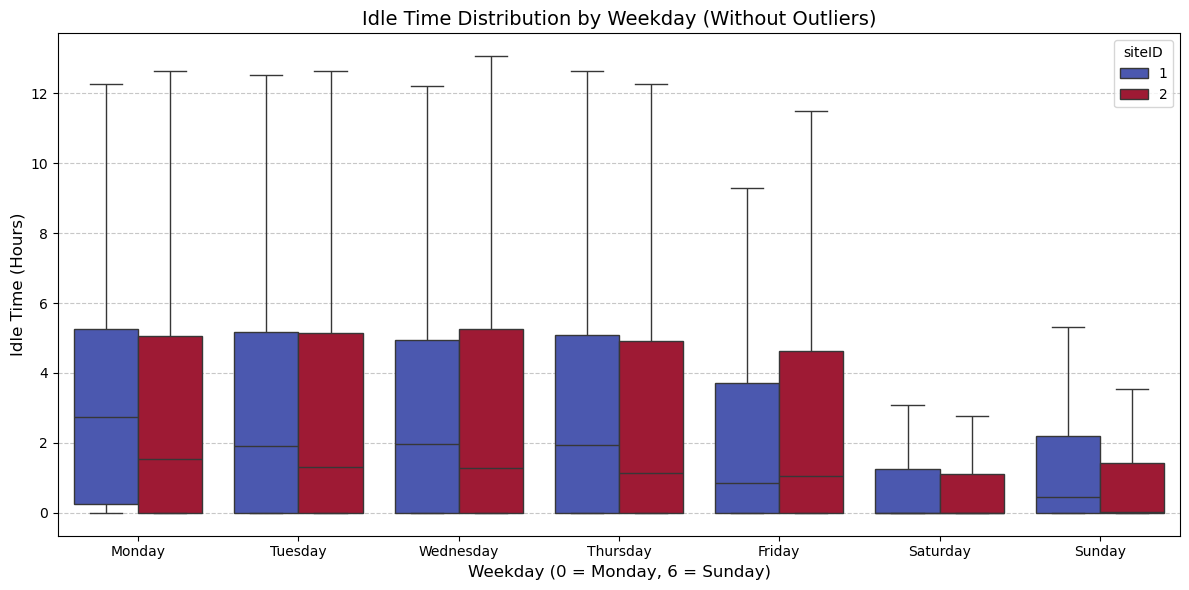

In [54]:
# Add a column for the weekday (0 = Monday, 6 = Sunday)
charging['weekday'] = charging['doneChargingTime'].dt.dayofweek

# Calculate idle time (in minutes)
charging['idle_time_minutes'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 60
charging['idle_time_hours'] = charging['idle_time_minutes'] / 60

# Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging, x='weekday', y='idle_time_hours', palette='coolwarm', hue='siteID', showfliers=False)

# Customize the plot
plt.title('Idle Time Distribution by Weekday (Without Outliers)', fontsize=14)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=12)
plt.ylabel('Idle Time (Hours)', fontsize=12)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# User inputs from registered users

First, create new subset with only registered users, to not falsify any visualizations. We do not need to compare metrics of registered users, like kWhRequested, with metrics of all users because this could lead to false conclusions (e.g. hypothetically all registered users request a lot of kWh and have cars that use a lot of kWh and also charge a lot of kWh. But if hypothetically every non registered user drives a car that does not use that much kWh, comparing them with a userInput a non resource intensive car user would potentially not request would lead to false conclusions). Also, we have tested comparisons with all users and the results are almost identical (We do not plot these anymore, as we have overwritten these plots with only consideration to registered users), so this statement is just a hunch from us and does have not come to a conclusion without the required data (Dont deduct points for this statement).

In [57]:
charging_only_registered = charging[charging['userInputs_paymentRequired'].notnull()].copy()

In [58]:
registered_users = charging.groupby('siteID')['userInputs_paymentRequired'].count()
registered_users

siteID
1    29561
2    17309
Name: userInputs_paymentRequired, dtype: int64

<b> Much more registered Users for site 1 even though unique userID count for both are similar </b>

## WhPerMile

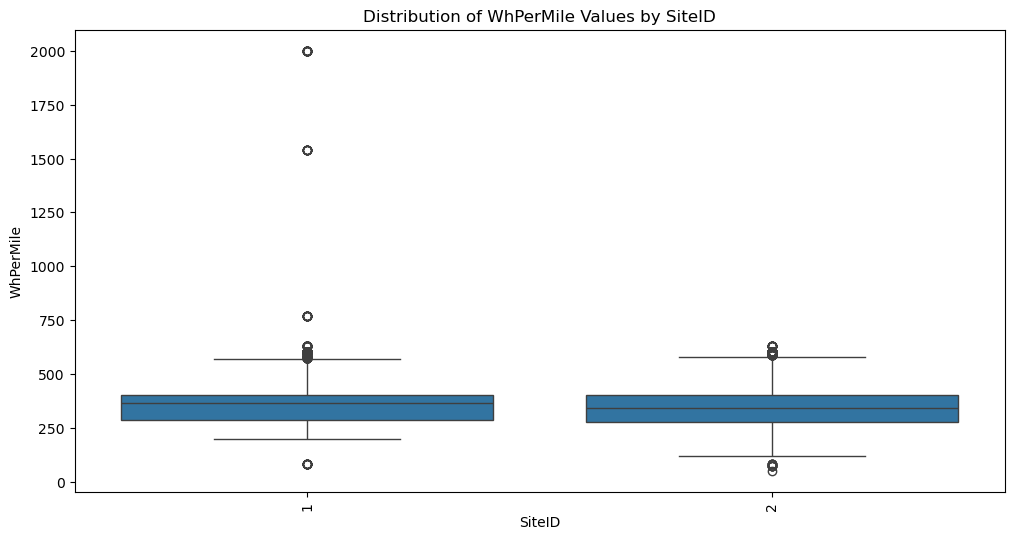

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='siteID', y='userInputs_WhPerMile', data=charging_only_registered)
plt.title('Distribution of WhPerMile Values by SiteID')
plt.xticks(rotation=90)
plt.xlabel('SiteID')
plt.ylabel('WhPerMile')
plt.show()

<b> Site 1 more efficient cars -> more expensive cars?

## kWhRequested vs actual kWhDelivered

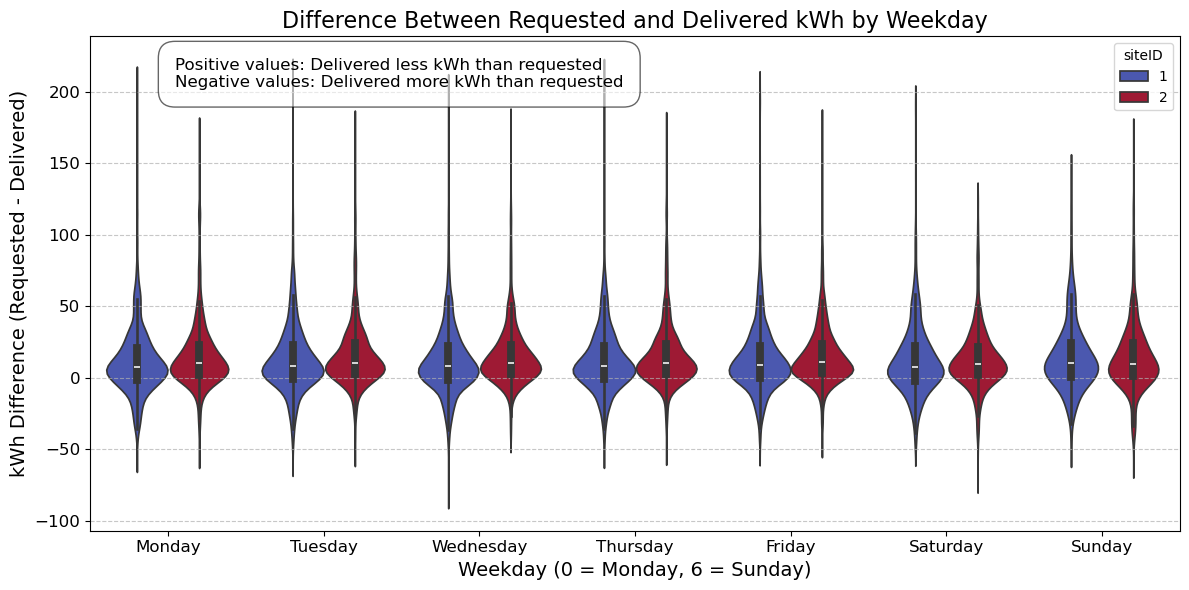

In [64]:
# Calculate idle time (in minutes)
charging_only_registered['kWhDiscrepancy'] = (charging_only_registered['userInputs_kWhRequested'] - charging_only_registered['kWhDelivered'])

# Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.violinplot(data=charging_only_registered, x='weekday', y='kWhDiscrepancy', palette='coolwarm', hue='siteID')

# Customize the plot
plt.title('Difference Between Requested and Delivered kWh by Weekday', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('kWh Difference (Requested - Delivered)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend or annotation for positive and negative values
plt.figtext(0.15, 0.85, 'Positive values: Delivered less kWh than requested\nNegative values: Delivered more kWh than requested', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

# Tight layout to prevent clipping
plt.tight_layout()
plt.show()

## requested Departure vs actual Departure (DisconnectTime)

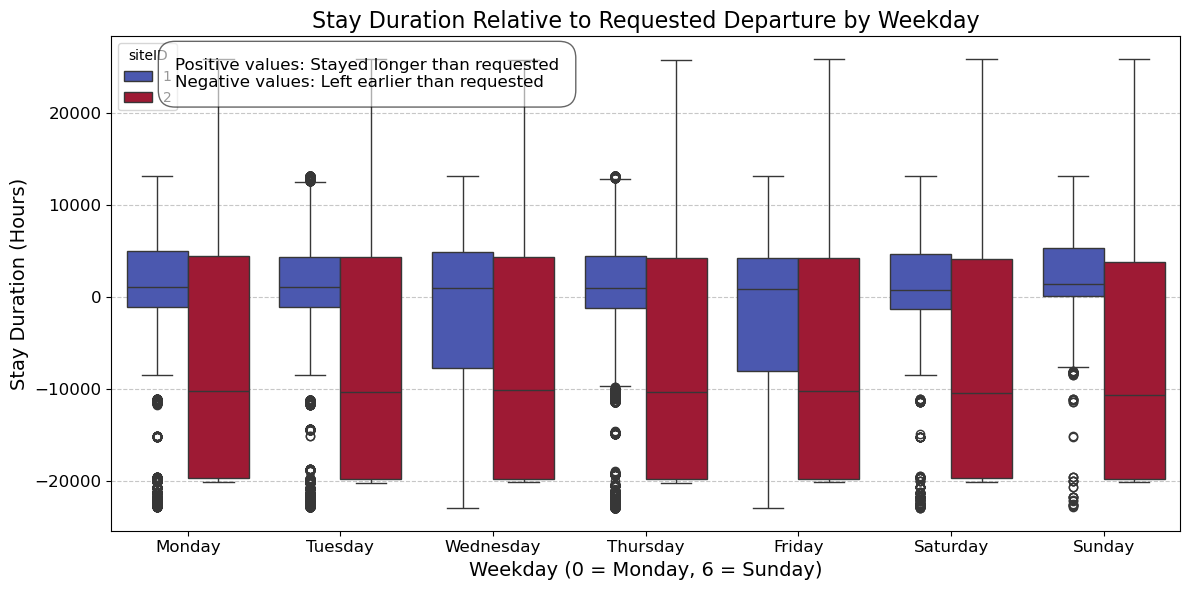

In [66]:
# Convert 'userInputs_requestedDeparture' to datetime with the correct format
charging_only_registered['requestedDeparture'] = pd.to_datetime(charging_only_registered['userInputs_requestedDeparture']).dt.tz_localize('UTC')

# Ensure 'disconnectTime' is also timezone-aware in UTC
charging_only_registered['disconnectTime'] = charging_only_registered['disconnectTime'].dt.tz_convert('UTC')

# Calculate stay duration in hours
charging_only_registered['stay_duration'] = (charging_only_registered['disconnectTime'] - charging_only_registered['requestedDeparture']).dt.total_seconds() / 3600

# Step 2: Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging_only_registered, x='weekday', y='stay_duration', palette='coolwarm', hue='siteID')

# Step 3: Customize the plot
plt.title('Stay Duration Relative to Requested Departure by Weekday', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Stay Duration (Hours)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Add a custom annotation for positive and negative values
plt.figtext(0.15, 0.85, 'Positive values: Stayed longer than requested\nNegative values: Left earlier than requested', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

# Step 5: Tight layout to prevent clipping
plt.tight_layout()
plt.show()

In [67]:
(charging_only_registered['disconnectTime'] - charging_only_registered['requestedDeparture']).dt.total_seconds()

0           -6039.0
1           -3209.0
2           34967.0
3            5621.0
4           25422.0
            ...    
63619    19799267.0
63620    19800468.0
63621    19782350.0
63622    19789299.0
63623    19795245.0
Length: 46870, dtype: float64

In [68]:
charging_only_registered['stay_duration'].max()

25853.152222222223

In [69]:
# Find the index of the maximum kWhDiscrepancy
max_discrepancy_index = charging_only_registered['kWhDiscrepancy'].idxmax()

# Retrieve the row with the highest discrepancy
max_discrepancy_row = charging_only_registered.loc[max_discrepancy_index]

max_discrepancy_row.id


'5c7ee8e3f9af8b1308c33a54'

In [70]:
charging_only_registered[charging_only_registered['id'] == '5c7ee8e3f9af8b1308c33a54']

id            connectionTime  \
55927  5c7ee8e3f9af8b1308c33a54 2019-01-24 14:36:03+00:00   

                 disconnectTime          doneChargingTime  kWhDelivered  \
55927 2019-01-24 23:36:20+00:00 2019-01-24 15:07:16+00:00         0.842   

                                    sessionID  siteID  spaceID    stationID  \
55927  1_1_179_800_2019-01-24 14:36:03.232399       1  AG-3F32  1-1-179-800   

       userID  ...  weekday  time_of_day  \
55927       0  ...        3         Noon   

                                            hourly_range  year month  \
55927  DatetimeIndex(['2019-01-24 14:00:00+00:00', '2...  2019     1   

      idle_time_minutes idle_time_hours  kWhDiscrepancy  \
55927        509.066667        8.484444         214.478   

             requestedDeparture stay_duration  
55927 2021-08-28 01:52:56+00:00 -22706.276667  

[1 rows x 34 columns]

<b> user input modified 2 years later und requested departure is also set 2 years later?! -> Maybe requested departure not usable because of this

## User estimated minutesAvailable vs Actual minutes (disconnect - connect Time)

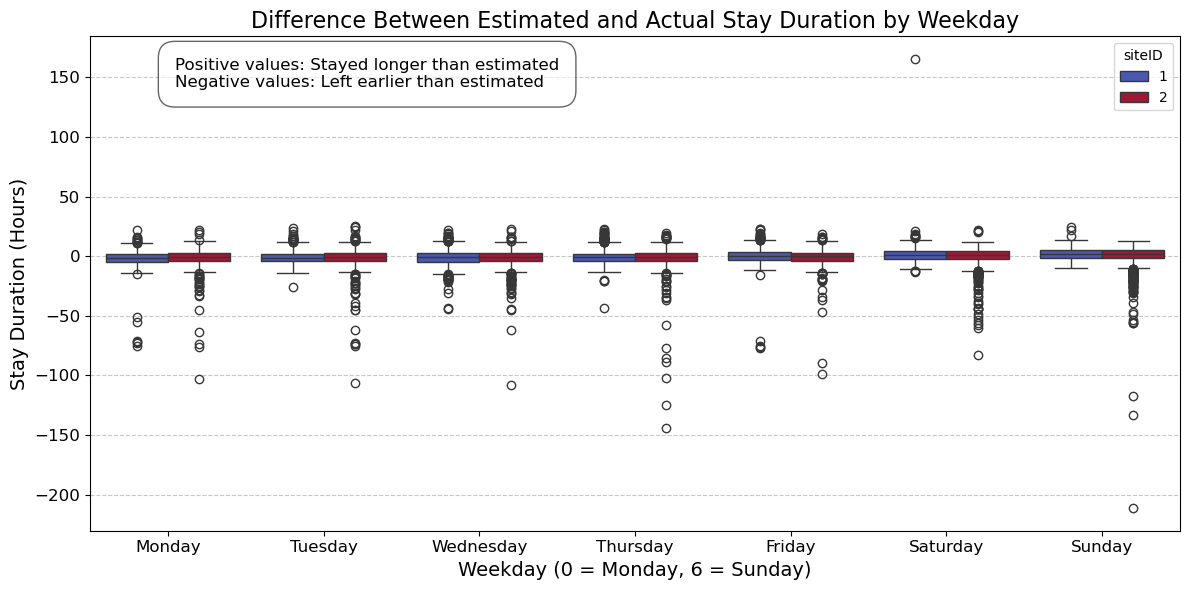

In [73]:
# Step 1: Ensure 'disconnectTime' is also timezone-aware in UTC
charging_only_registered['disconnectTime'] = charging_only_registered['disconnectTime'].dt.tz_convert('UTC')

charging_only_registered['stay_duration'] = (charging_only_registered['userInputs_minutesAvailable'] - ((charging_only_registered['disconnectTime'] - charging_only_registered['connectionTime']).dt.total_seconds() / 60)) / 60

# Step 2: Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging_only_registered, x='weekday', y='stay_duration', palette='coolwarm', hue='siteID')

# Step 3: Customize the plot
plt.title('Difference Between Estimated and Actual Stay Duration by Weekday', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Stay Duration (Hours)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Add a custom annotation for positive and negative values
plt.figtext(0.15, 0.85, 'Positive values: Stayed longer than estimated\nNegative values: Left earlier than estimated', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

# Step 5: Tight layout to prevent clipping
plt.tight_layout()
plt.show()


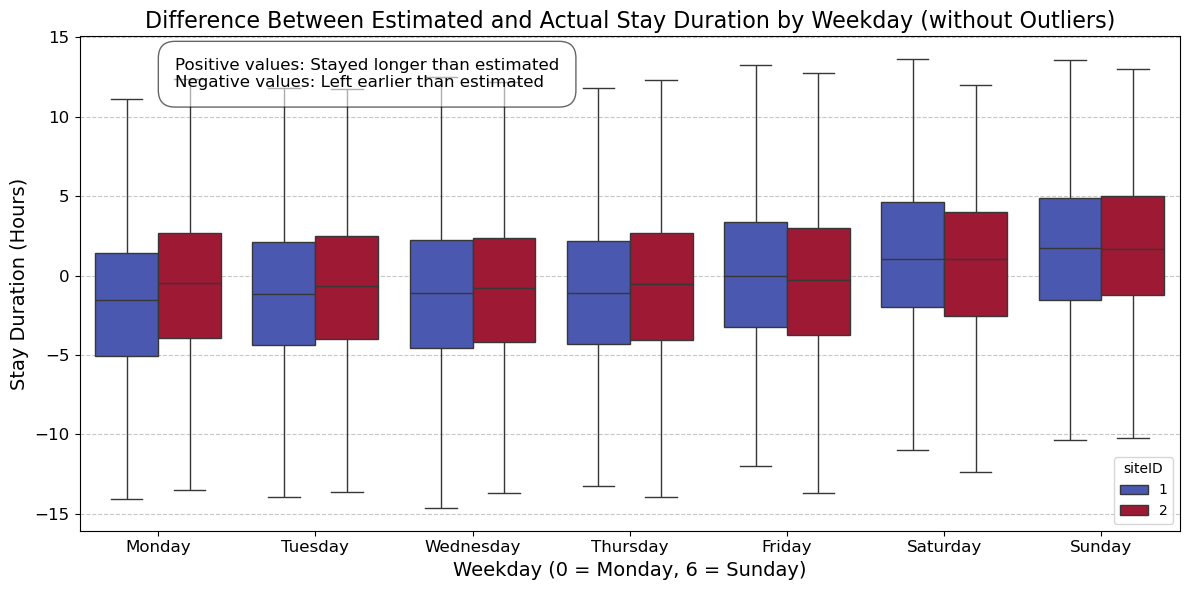

In [74]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging_only_registered, x='weekday', y='stay_duration', palette='coolwarm', hue='siteID', showfliers=False)

plt.title('Difference Between Estimated and Actual Stay Duration by Weekday (without Outliers)', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Stay Duration (Hours)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.figtext(0.15, 0.85, 'Positive values: Stayed longer than estimated\nNegative values: Left earlier than estimated', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

plt.tight_layout()
plt.show()


# Weather

In [76]:
weather.head(15)

timestamp  temperature  cloud_cover cloud_cover_description  \
0  2018-01-01 08:53:00          9.0         33.0                    Fair   
1  2018-01-01 09:53:00          9.0         33.0                    Fair   
2  2018-01-01 10:53:00          9.0         21.0                    Haze   
3  2018-01-01 11:53:00          9.0         29.0           Partly Cloudy   
4  2018-01-01 12:53:00          8.0         33.0                    Fair   
5  2018-01-01 13:53:00          8.0         33.0                    Fair   
6  2018-01-01 14:53:00          7.0         30.0           Partly Cloudy   
7  2018-01-01 15:53:00          8.0         34.0                    Fair   
8  2018-01-01 16:53:00         12.0         34.0                    Fair   
9  2018-01-01 17:53:00         16.0         34.0                    Fair   
10 2018-01-01 18:53:00         19.0         34.0                    Fair   
11 2018-01-01 19:53:00         21.0         34.0                    Fair   
12 2018-01-01 20:53:00         22.0         34.0                    Fair   
13 2018-01-01 21:53:00         23.0         34.0                    Fair   
14 2018-01-01 22:53:00         23.0         34.0                    Fair   

    pressure  windspeed  precipitation  felt_temperature  
0     991.75        9.0            0.0               8.0  
1     992.08        0.0            0.0               9.0  
2     992.08        0.0            0.0               9.0  
3     992.08        0.0            0.0               9.0  
4     992.08        0.0            0.0               8.0  
5     992.08        0.0            0.0               8.0  
6     992.08        0.0            0.0               7.0  
7     992.41        0.0            0.0               8.0  
8     993.39        0.0            0.0              12.0  
9     994.05        0.0            0.0              16.0  
10    993.72        0.0            0.0              19.0  
11    992.41        7.0            0.0              21.0  
12    991.09        0.0            0.0              22.0  
13    990.10        6.0            0.0              23.0  
14    990.43        7.0            0.0              23.0

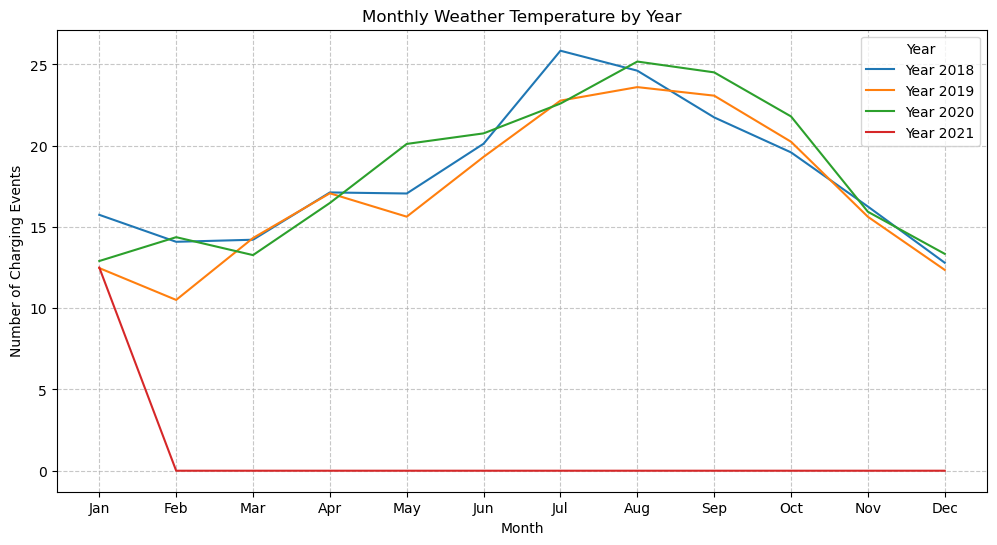

In [77]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['temperature'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Weather Temperature by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

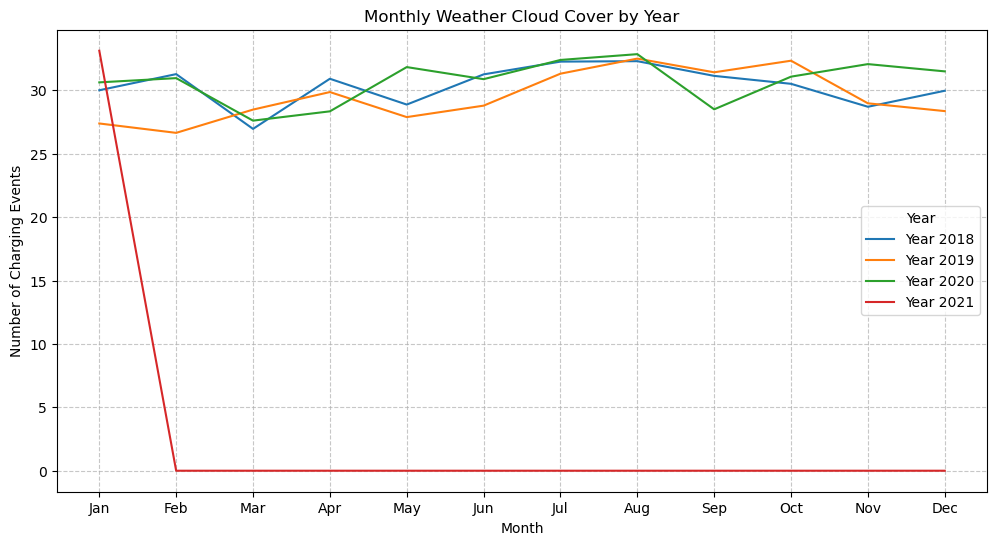

In [78]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['cloud_cover'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Weather Cloud Cover by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

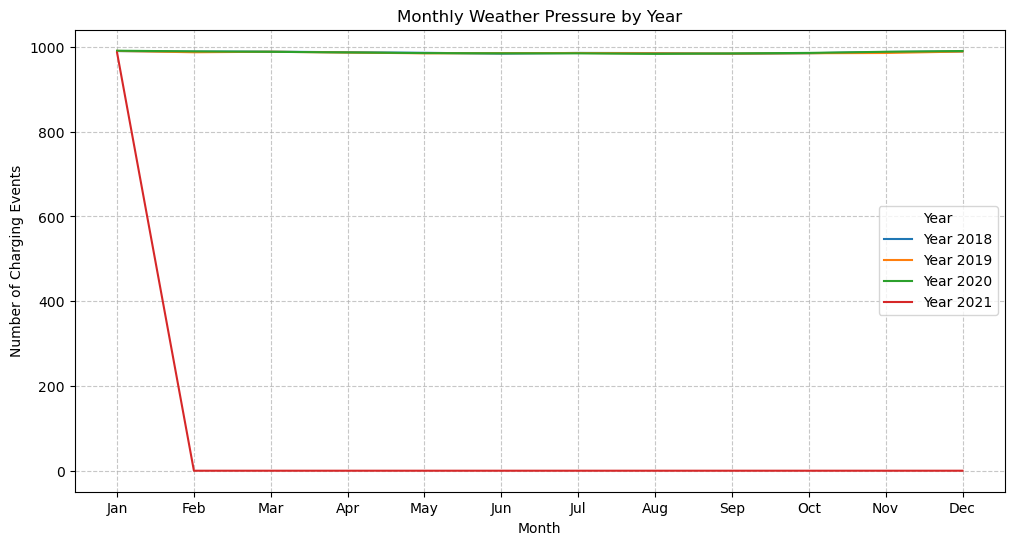

In [79]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['pressure'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Weather Pressure by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

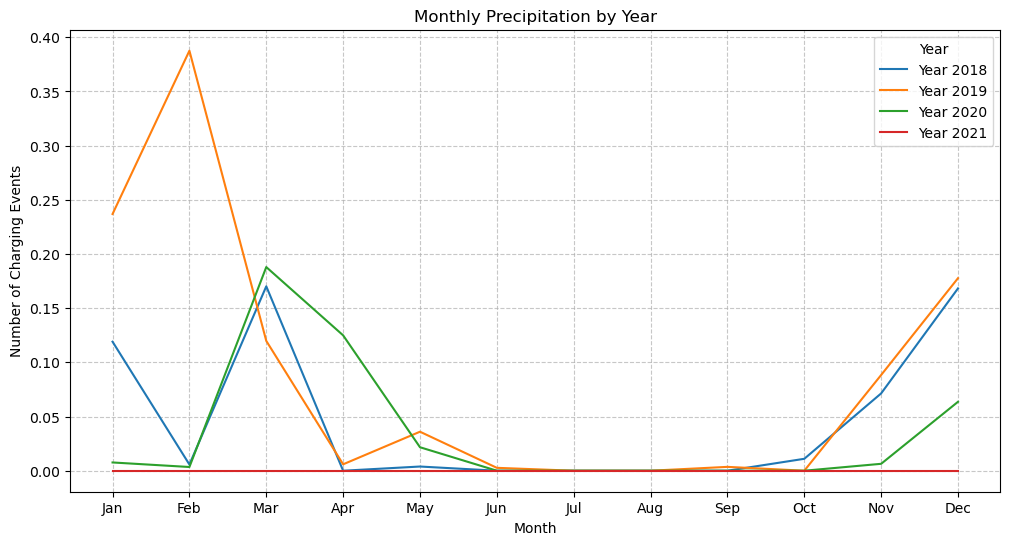

In [80]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['precipitation'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Precipitation by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<h2> Show plot with x from 2018 to 2021 for seasonality </h2>

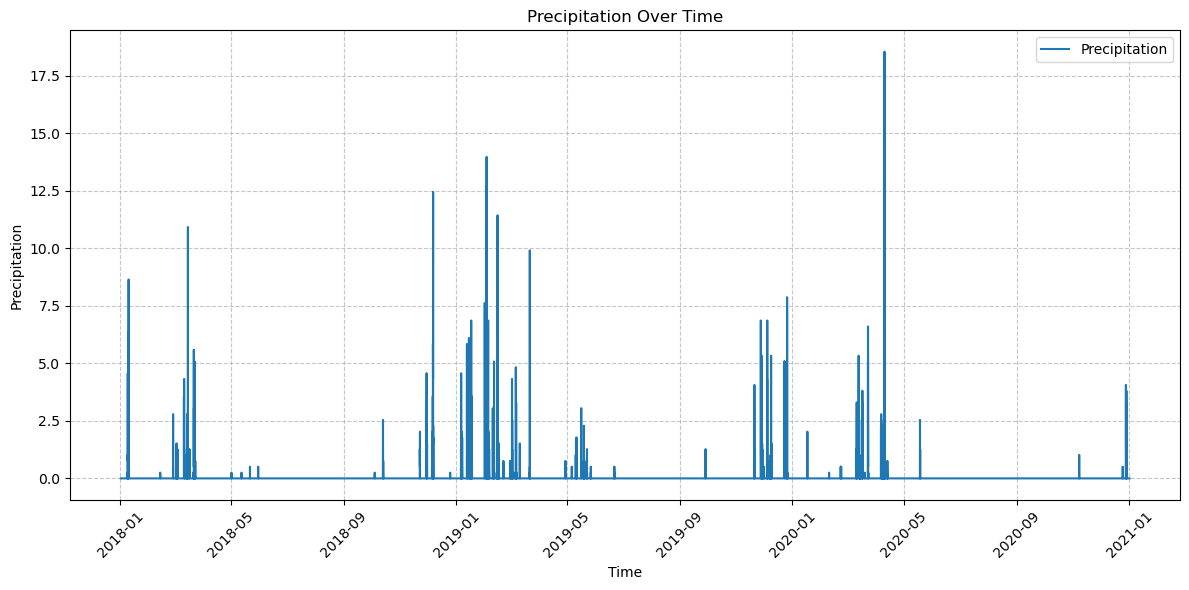

In [82]:
# Assuming 'weather' is your DataFrame and 'timestamp' is already in datetime format
plt.figure(figsize=(12, 6))

# Plot the precipitation over the entire timespan
plt.plot(weather['timestamp'], weather['precipitation'], label="Precipitation")

# Add labels, title, and legend
plt.title("Precipitation Over Time")
plt.xlabel("Time")
plt.ylabel("Precipitation")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

<h2> Idea: konfidenzintervall </h2>

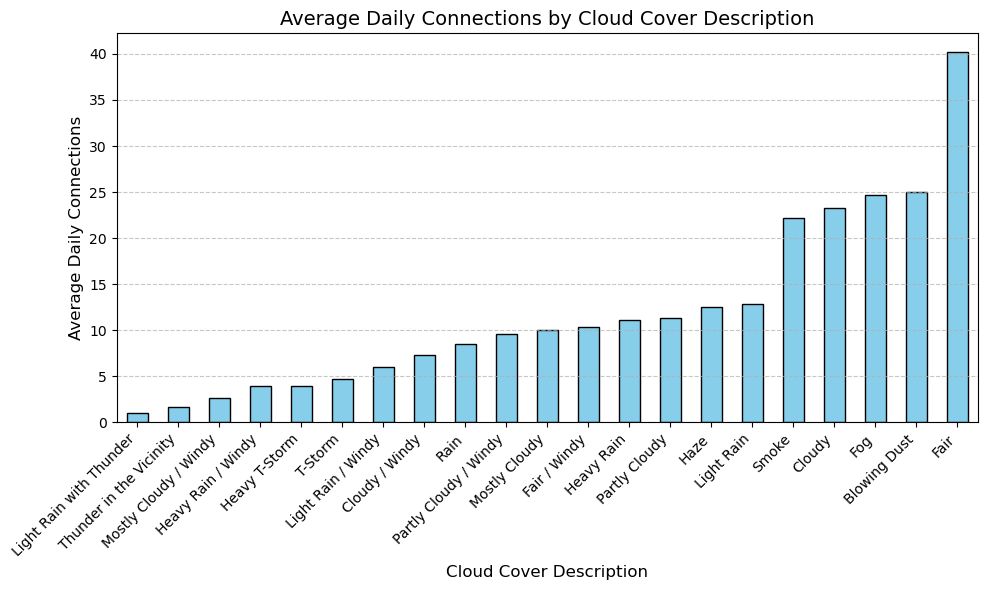

In [84]:
# Convert `timestamp` in `weather` to UTC to match `connectionTime`
weather['timestamp'] = weather['timestamp'].dt.tz_localize('UTC')

# Merge charging and weather data on the nearest time
merged_data = pd.merge_asof(
    charging.sort_values('connectionTime'),
    weather.sort_values('timestamp'),
    left_on='connectionTime',
    right_on='timestamp',
    direction='backward'
)

# Extract the date part for daily aggregation
merged_data['date'] = merged_data['connectionTime'].dt.date

# Group by date and cloud description, count connections
daily_connections = merged_data.groupby(['date', 'cloud_cover_description']).size().reset_index(name='connections')

# Calculate the average daily connections for each cloud description
avg_daily_connections = daily_connections.groupby('cloud_cover_description')['connections'].mean()

# Plot the bar chart
plt.figure(figsize=(10, 6))
avg_daily_connections.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels, title, and grid
plt.title("Average Daily Connections by Cloud Cover Description", fontsize=14)
plt.xlabel("Cloud Cover Description", fontsize=12)
plt.ylabel("Average Daily Connections", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

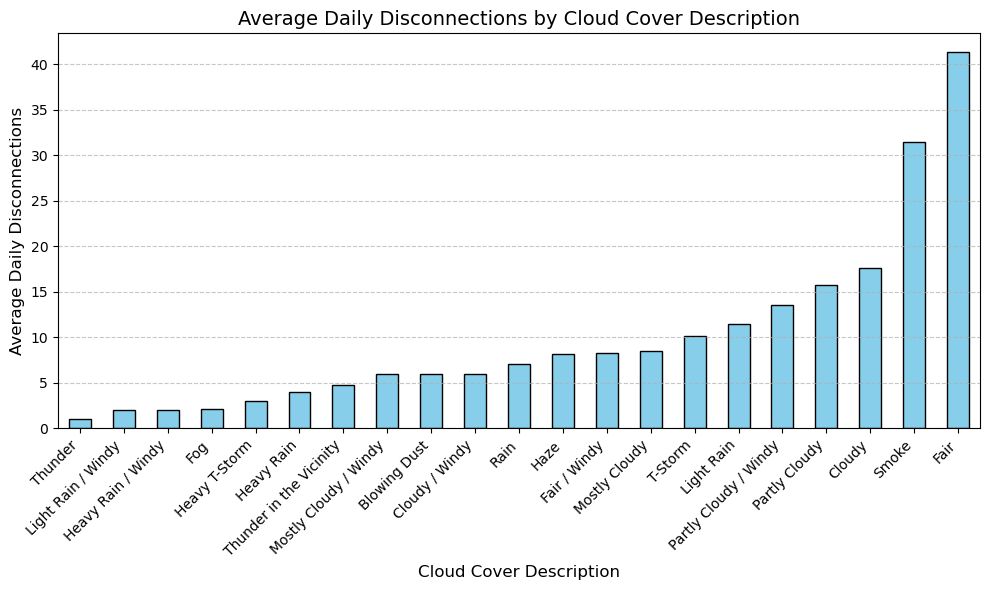

In [85]:
# Merge charging and weather data on the nearest time
merged_data = pd.merge_asof(
    charging.sort_values('disconnectTime'),
    weather.sort_values('timestamp'),
    left_on='disconnectTime',
    right_on='timestamp',
    direction='backward'
)

# Extract the date part for daily aggregation
merged_data['date'] = merged_data['disconnectTime'].dt.date

# Group by date and cloud description, count connections
daily_disconnections = merged_data.groupby(['date', 'cloud_cover_description']).size().reset_index(name='connections')

# Calculate the average daily connections for each cloud description
avg_daily_disconnections = daily_disconnections.groupby('cloud_cover_description')['connections'].mean()

# Plot the bar chart
plt.figure(figsize=(10, 6))
avg_daily_disconnections.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels, title, and grid
plt.title("Average Daily Disconnections by Cloud Cover Description", fontsize=14)
plt.xlabel("Cloud Cover Description", fontsize=12)
plt.ylabel("Average Daily Disconnections", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

<h4>Interpretation</h4>

We see multiple things:

1. 2018 and 2019 had more sessions than the other years -> In year 2020 pandemic started and this could have resulted in a reduction commuting and traveling, reduction imports for material for these vehicles ect. so the use of e-vehicles also decreased from 2020 on

2. **Some month are not recorded in the data, such as the first three months of 2018 and the last 3 months of 2021 and september + october of 2020 -> why?**

3. In year 2020, the demand significantly went down from april on and stayed on a very low level for the rest of the year -> can be attributed to covid

4. In year 2021, chargign sessions went up again -> "recovery" from covid, restrictions weren't that strict anymore

<h1>Temperature Specific Use Patterns </h1>

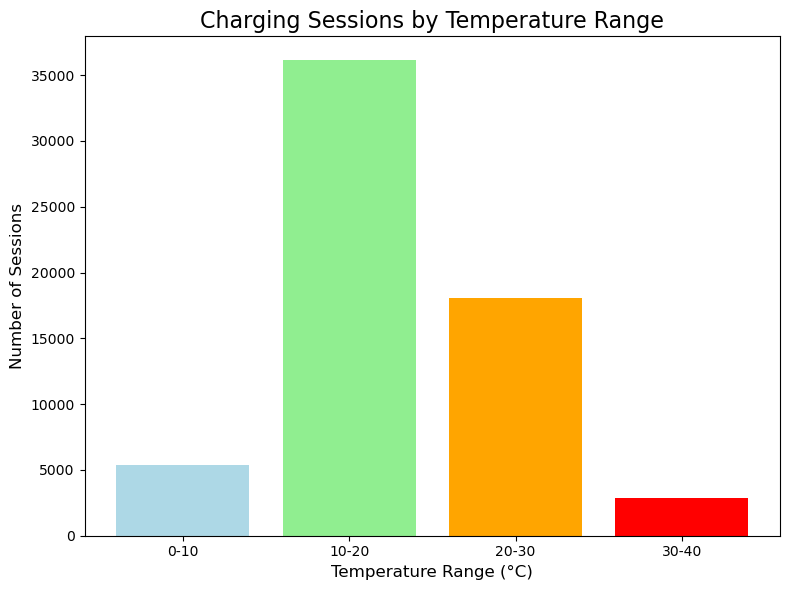

In [88]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'], utc=True)
weather['timestamp'] = pd.to_datetime(weather['timestamp'], utc=True)

charging['hour'] = charging['connectionTime'].dt.floor('h')

weather['hour'] = weather['timestamp'].dt.floor('h')

merged_data = pd.merge(
    charging,
    weather[['hour', 'temperature']], 
    on='hour', 
    how='inner'
)

bins = [0, 10, 20, 30, 40]
labels = ['0-10', '10-20', '20-30', '30-40']
merged_data['temp_range'] = pd.cut(merged_data['temperature'], bins=bins, labels=labels, right=False)

session_counts = merged_data['temp_range'].value_counts().sort_index()
colors = ['lightblue', 'lightgreen', 'orange', 'red']

plt.figure(figsize=(8, 6))
bars = plt.bar(session_counts.index, session_counts.values, color=colors)

plt.title('Charging Sessions by Temperature Range', fontsize=16)
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.tight_layout()
plt.show()


As we can see, most sessions occur in moderate temperatures between 10 and 30. Sesisons in colder (0-10) or hotter (30-40) degrees are more rare which makes more sense because EV cars have lower range on extrem temperatures like cold or hot weather (provide source here)

# Usage station specific

In [91]:
charging_stations = charging.groupby('siteID')['stationID'].nunique()
charging_stations

siteID
1    52
2    55
Name: stationID, dtype: int64

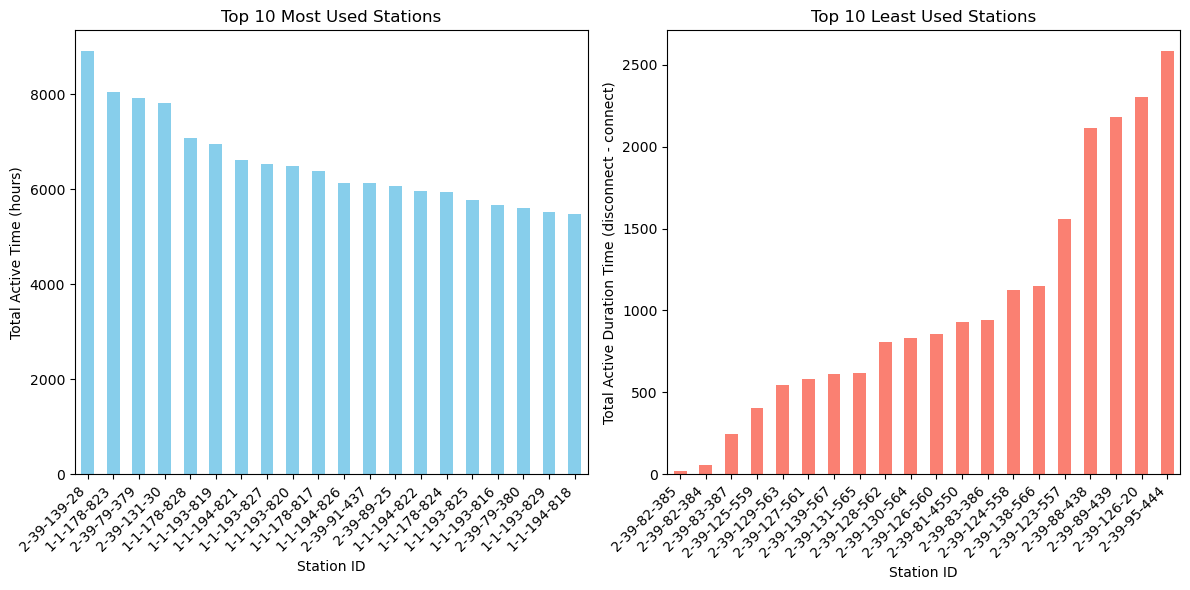

In [92]:
charging['duration'] = (charging['disconnectTime'] - charging['connectionTime']).dt.total_seconds() / 3600

station_active_time = charging.groupby('stationID')['duration'].sum()

most_used_stations = station_active_time.sort_values(ascending=False).head(20)

most_unused_stations = station_active_time.sort_values(ascending=True).head(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
most_used_stations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Used Stations')
plt.xlabel('Station ID')
plt.ylabel('Total Active Time (hours)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
most_unused_stations.plot(kind='bar', color='salmon')
plt.title('Top 10 Least Used Stations')
plt.xlabel('Station ID')
plt.ylabel('Total Active Duration Time (disconnect - connect)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


<h2> Show duration time for all Stations -> only one plot per site, different colors for each site</h2>

As we can see, stations of site 1 are much more used than stations of site 2 -> indication that site 2 might be the private site

# Task 2 b.) - KPI

<h2> Task

<h2>First KPI: Idle Time </h2>

This insight into the efficiency and utilization of charging stations. By monitoring the time between when charging is complete and when the vehicle is unplugged, operators can assess whether resources are being optimally used and to which degree some stations are being used by already full charged cars.

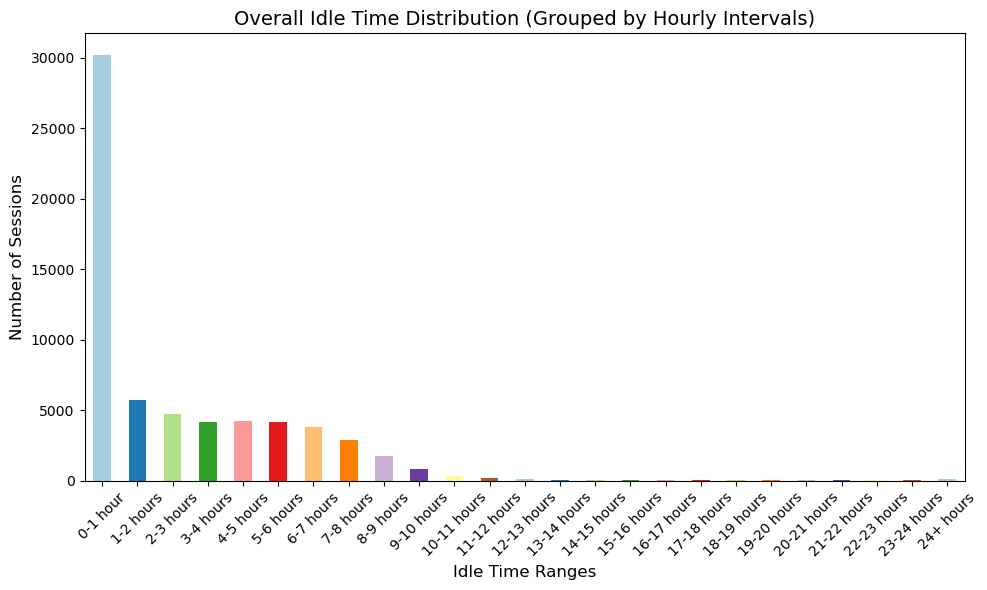

In [98]:
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['idle_time'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 3600

charging['idle_time'] = charging['idle_time'].apply(lambda x: max(x, 0))

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, float('inf')]
labels = ['0-1 hour', '1-2 hours', '2-3 hours', '3-4 hours', '4-5 hours', '5-6 hours', '6-7 hours', '7-8 hours', '8-9 hours', 
          '9-10 hours', '10-11 hours', '11-12 hours', '12-13 hours', '13-14 hours', '14-15 hours', '15-16 hours', 
          '16-17 hours', '17-18 hours', '18-19 hours', '19-20 hours', '20-21 hours', '21-22 hours', '22-23 hours', 
          '23-24 hours', '24+ hours']

charging['idle_time_bins'] = pd.cut(charging['idle_time'], bins=bins, labels=labels, right=False)

idle_time_distribution = charging['idle_time_bins'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
idle_time_distribution.plot(kind='bar', color=plt.cm.Paired.colors)
plt.title('Overall Idle Time Distribution (Grouped by Hourly Intervals)', fontsize=14)
plt.xlabel('Idle Time Ranges', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


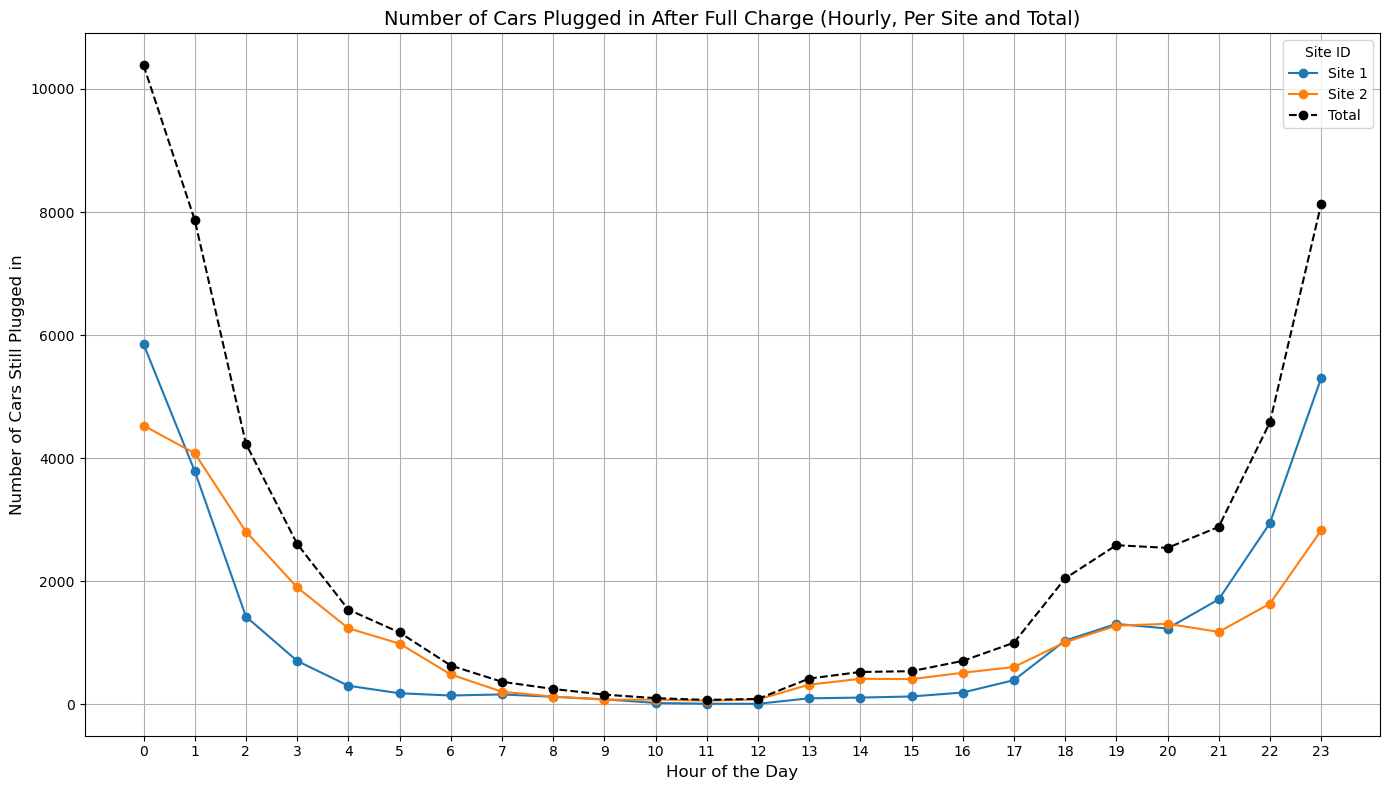

In [99]:
# Calculate idle time in hours
charging['idle_time'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 3600

# Filter out rows with negative or zero idle_time
charging_after_full_charge = charging[charging['idle_time'] > 0].copy()

# Extract disconnect hour safely
charging_after_full_charge.loc[:, 'disconnect_hour'] = charging_after_full_charge['disconnectTime'].dt.hour

# Group by site and hour to calculate the number of idle sessions
hourly_idle_sessions_by_site = (
    charging_after_full_charge
    .groupby(['siteID', 'disconnect_hour'])
    .size()
    .reset_index(name='idle_session_count')
)

# Calculate the total idle sessions across all sites for each hour
hourly_idle_sessions_total = (
    charging_after_full_charge
    .groupby('disconnect_hour')
    .size()
    .reset_index(name='idle_session_count')
)

# Plot the results for each site
plt.figure(figsize=(14, 8))
for site_id in hourly_idle_sessions_by_site['siteID'].unique():
    site_data = hourly_idle_sessions_by_site[hourly_idle_sessions_by_site['siteID'] == site_id]
    plt.plot(
        site_data['disconnect_hour'],
        site_data['idle_session_count'],
        marker='o',
        label=f'Site {site_id}'
    )

# Add the total line to the plot
plt.plot(
    hourly_idle_sessions_total['disconnect_hour'],
    hourly_idle_sessions_total['idle_session_count'],
    marker='o',
    linestyle='--',
    color='black',
    label='Total'
)

# Add plot labels, title, and legend
plt.title('Number of Cars Plugged in After Full Charge (Hourly, Per Site and Total)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Cars Still Plugged in', fontsize=12)
plt.xticks(range(0, 24, 1))
plt.grid(True)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()

The high idle time during nights suggests that cars are staying plugged in after they’re fully charged, taking up valuable charging spots. 

To improve this, the hub operator could consider adding fees for cars that stay plugged in after they’re fully charged. Charging a small fee for idle time would encourage users to unplug their cars more quickly. This would help make better use of the charging stations, as people would be more likely to avoid the fee. The fee could be based on how long the car has been plugged in after charging is complete (e.g. 0 to 1 hour, 1 to 2 hours ect.), ensuring it’s fair while addressing the issue of idle cars. It would also free up spots for others and could generate some additional revenue for the hub.

<h2> Second KPI: Kwh Requested vs delivered </h2>

Important: Only possible for registered users!

We chose this KPI to see how well the charging stations are meeting user expectations. By comparing the energy requsted by users with the energy delivered, we can quickly spot any gaps in sevrice. If users consistently ask for more energy than they get, it could signal issues like slow charging speeds, underpowered stations, or even problems with how users estimate their needs.

For the business owner, this is important because if there's a big difference between requested and delivered energy, it might mean customers aren’t getting what they expect, which can lead to frustration and potentially fewer users. By tracking this, the hub operator can make improvements, like upgrading equipment or adjusting operations, to better serve customers and increase station usage.

From the data, it’s clear that users almost always request more energy than they actually receive. This points to possible inefficiencies in the system or misestimations by users. For the operator, addressing this could lead to better customer experiences and a more efficient use of resources.

To improve the gap between requested and delivered energy, the operator should consider upgrading the charging infrastructure to handle higher energy demands and optimizing charging speeds to ensure users receive the energy they requested. This would enhance customer satisfaction and increase the efficiency of the charging hubs.

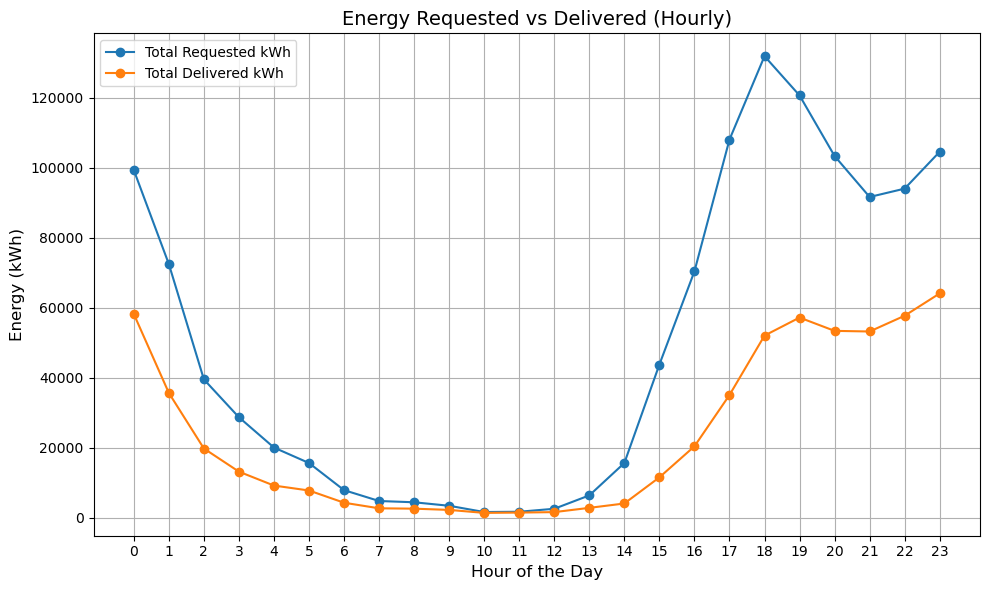

Number of rows after filtering (requested kWh): 46870


C:\Users\Willi\AppData\Local\Temp\ipykernel_12772\3668244582.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_filtered['doneChargingTime'] = pd.to_datetime(charging_filtered['doneChargingTime'])
C:\Users\Willi\AppData\Local\Temp\ipykernel_12772\3668244582.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_filtered['hour'] = charging_filtered['doneChargingTime'].dt.hour


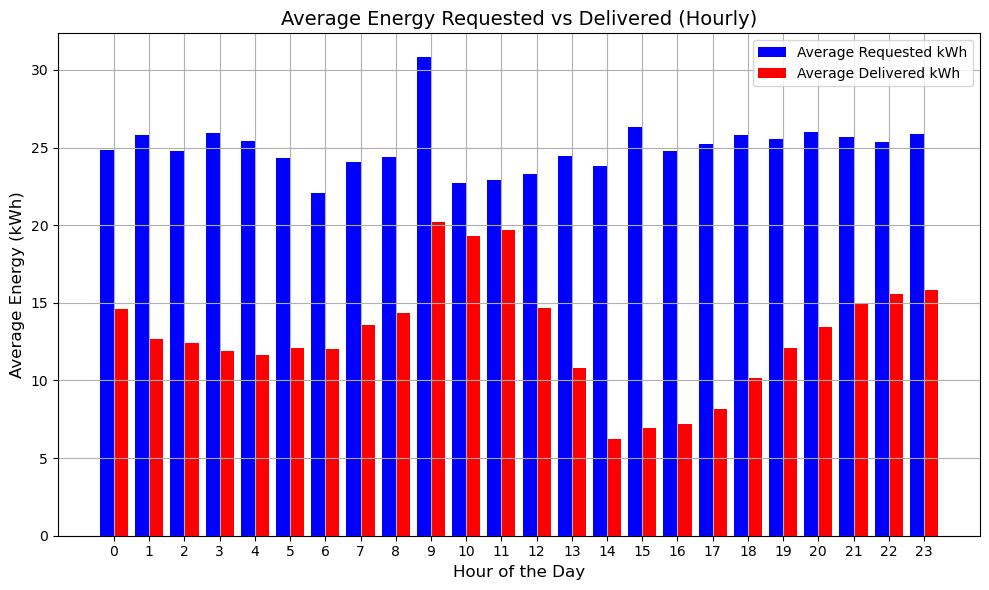

In [102]:
# Filter out rows where 'userInputs_kWhRequested' is null
charging_filtered = charging[charging['userInputs_kWhRequested'].notnull()].copy()

# Get the number of rows where 'userInputs_kWhRequested' is not null
num_rows = charging_filtered['userInputs_kWhRequested'].count()

# Proceed with your analysis
charging_filtered['doneChargingTime'] = pd.to_datetime(charging_filtered['doneChargingTime'])
charging_filtered['hour'] = charging_filtered['doneChargingTime'].dt.hour

# Aggregate total requested and delivered kWh by hour
hourly_energy = charging_filtered.groupby('hour').agg(
    total_requested_kWh=('userInputs_kWhRequested', 'sum'),
    total_delivered_kWh=('kWhDelivered', 'sum')
).reset_index()

# Plotting total requested vs delivered kWh
plt.figure(figsize=(10, 6))
plt.plot(hourly_energy['hour'], hourly_energy['total_requested_kWh'], label='Total Requested kWh', marker='o')
plt.plot(hourly_energy['hour'], hourly_energy['total_delivered_kWh'], label='Total Delivered kWh', marker='o')
plt.title('Energy Requested vs Delivered (Hourly)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend()
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter out rows where 'userInputs_kWhRequested' is null (again for other plots)
charging_filtered = charging[charging['userInputs_kWhRequested'].notnull()]

# Get the number of rows where 'userInputs_kWhRequested' is not null
num_rows = charging_filtered['userInputs_kWhRequested'].count()
print(f"Number of rows after filtering (requested kWh): {num_rows}")

charging_filtered['doneChargingTime'] = pd.to_datetime(charging_filtered['doneChargingTime'])
charging_filtered['hour'] = charging_filtered['doneChargingTime'].dt.hour

# Aggregate average requested and delivered kWh by hour
hourly_avg_energy = charging_filtered.groupby('hour').agg(
    avg_requested_kWh=('userInputs_kWhRequested', 'mean'),
    avg_delivered_kWh=('kWhDelivered', 'mean')
).reset_index()

# Ensure 'hour' is numeric for arithmetic operations
hourly_avg_energy['hour'] = hourly_avg_energy['hour'].astype(int)

# Plotting average requested vs delivered kWh
plt.figure(figsize=(10, 6))
plt.bar(hourly_avg_energy['hour'] - 0.2, hourly_avg_energy['avg_requested_kWh'], width=0.4, label='Average Requested kWh', color='blue')
plt.bar(hourly_avg_energy['hour'] + 0.2, hourly_avg_energy['avg_delivered_kWh'], width=0.4, label='Average Delivered kWh', color='red')

plt.title('Average Energy Requested vs Delivered (Hourly)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Energy (kWh)', fontsize=12)
plt.legend()
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of requested vs delivered energy
# charging_filtered = charging[charging['userInputs_kWhRequested'].notnull()].copy()
# num_rows = charging_filtered['userInputs_kWhRequested'].count()

# plt.figure(figsize=(10, 6))
# sns.boxplot(data=charging_filtered, x='hour', y='userInputs_kWhRequested', color='blue', label='Requested kWh')
# sns.boxplot(data=charging_filtered, x='hour', y='kWhDelivered', color='red', label='Delivered kWh')

# plt.title('Distribution of Energy Requested vs Delivered (Hourly)', fontsize=14)
# plt.xlabel('Hour of the Day', fontsize=12)
# plt.ylabel('Energy (kWh)', fontsize=12)
# plt.legend()
# plt.tight_layout()
# plt.show()

# Pivot table and heatmap
# charging_filtered = charging[charging['userInputs_kWhRequested'].notnull()]
# num_rows = charging_filtered['userInputs_kWhRequested'].count()

# hourly_pivot = charging_filtered.pivot_table(
#     values=['userInputs_kWhRequested', 'kWhDelivered'],
#     index='hour',
#     aggfunc='mean'
# )

# plt.figure(figsize=(10, 6))
# sns.heatmap(hourly_pivot, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'kWh'})
# plt.title('Heatmap of Average Energy Requested and Delivered (Hourly)', fontsize=14)
# plt.xlabel('Energy Type', fontsize=12)
# plt.ylabel('Hour of the Day', fontsize=12)
# plt.tight_layout()
# plt.show()

<b> Note that we compare kwh delivered of all users (registered and not) vs kwh requested of only registered users

## KPI 3: Active sessions

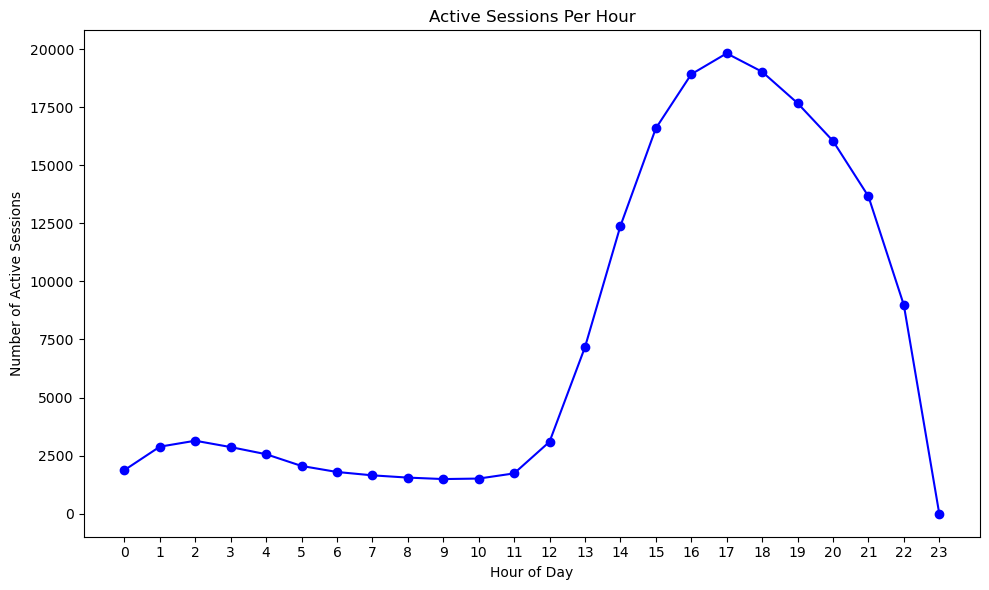

In [105]:
# Extract the hour from connectionTime and disconnectTime
charging['connection_hour'] = charging['connectionTime'].dt.hour
charging['disconnect_hour'] = charging['disconnectTime'].dt.hour

# Define the active sessions: sessions that started before or during the hour and have not disconnected before the hour
active_sessions_per_hour = []

for hour in range(24):
    # Sessions that started on or before the current hour
    sessions_started = charging[charging['connection_hour'] <= hour]
    
    # Sessions that have not disconnected before the current hour
    sessions_active = sessions_started[sessions_started['disconnect_hour'] > hour]
    
    active_sessions_per_hour.append(sessions_active.shape[0])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(24), active_sessions_per_hour, marker='o', linestyle='-', color='b')

# Set labels and title
plt.title('Active Sessions Per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Active Sessions')

# Format x-axis to show hours from 0 to 23
plt.xticks(range(0, 24))

# Show the plot
plt.tight_layout()
plt.show()

## KPI 4: Minutes Available vs actual Minutes (DisconnectTime - ConnectionTime)

<Figure size 1200x600 with 0 Axes>

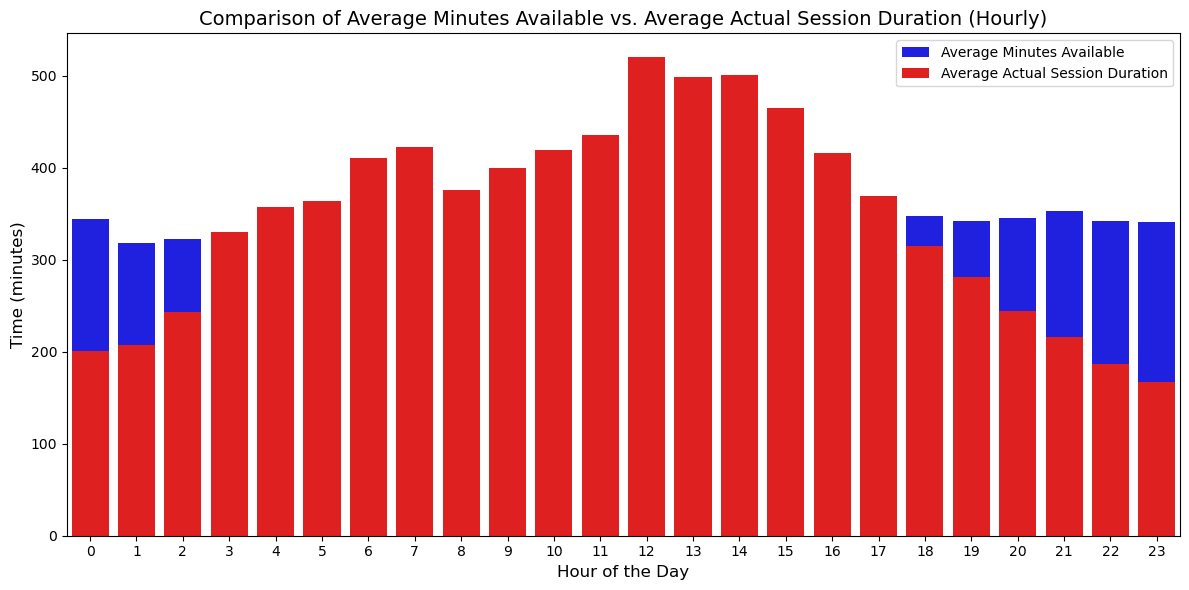

In [107]:
# Extract the hour from 'connectionTime'
charging['hour'] = charging['connectionTime'].dt.hour

charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['minutesAvailable'] = charging['userInputs_minutesAvailable'].astype(float)

charging['actualSessionDuration'] = (charging['disconnectTime'] - charging['connectionTime']).dt.total_seconds() / 60

charging['kpi_minutes_diff'] = charging['minutesAvailable'] - charging['actualSessionDuration']

plt.figure(figsize=(12, 6))

# Group by hour and calculate the average of 'minutesAvailable' and 'actualSessionDuration'
hourly_comparison = charging.groupby('hour').agg(
    avg_minutes_available=('minutesAvailable', 'mean'),
    avg_actual_session_duration=('actualSessionDuration', 'mean')
).reset_index()

# Plotting the comparison
plt.figure(figsize=(12, 6))

# Plotting both average values in a bar plot for comparison
sns.barplot(data=hourly_comparison, x='hour', y='avg_minutes_available', color='blue', label='Average Minutes Available')
sns.barplot(data=hourly_comparison, x='hour', y='avg_actual_session_duration', color='red', label='Average Actual Session Duration')

# Add labels and title
plt.title('Comparison of Average Minutes Available vs. Average Actual Session Duration (Hourly)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)

# Add a legend
plt.legend()

# Adjust layout
plt.xticks(range(24))  # Ensure we have all hours from 0 to 23
plt.tight_layout()
plt.show()

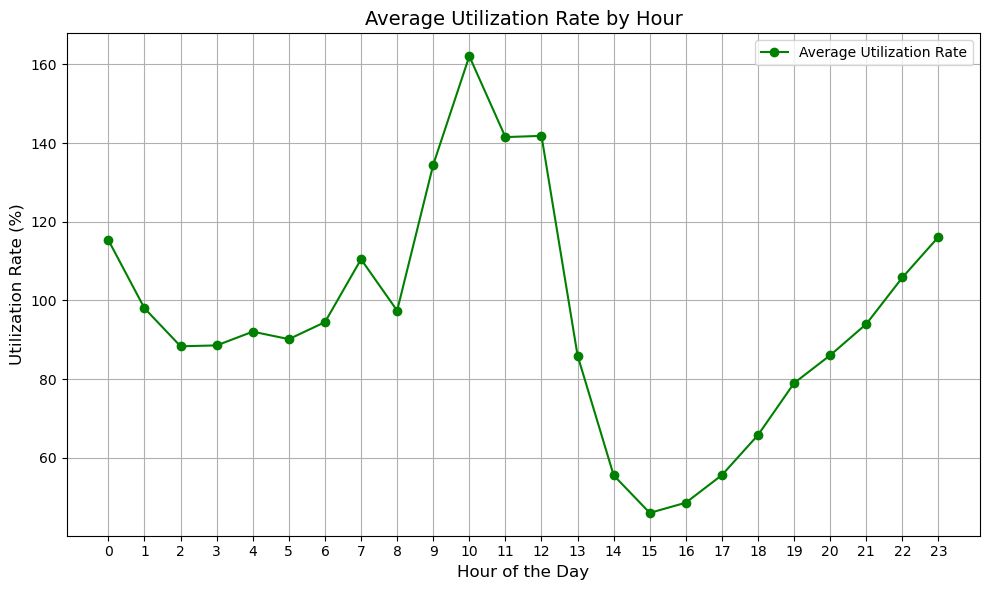

In [108]:
charging_code2 = charging.copy()

# Convert necessary columns to datetime
charging_code2['connectionTime'] = pd.to_datetime(charging_code2['connectionTime'])
charging_code2['disconnectTime'] = pd.to_datetime(charging_code2['doneChargingTime'])

# Calculate the actual session duration in minutes
charging_code2['actualSessionDuration'] = (charging_code2['doneChargingTime'] - charging_code2['connectionTime']).dt.total_seconds() / 60

# Ensure minutesAvailable is a float
charging_code2['minutesAvailable'] = charging_code2['userInputs_minutesAvailable'].astype(float)

# Extract the hour of doneChargingTime
charging_code2['hour'] = charging_code2['doneChargingTime'].dt.hour

# Group by hour and calculate total session duration and total available time
hourly_data = charging_code2.groupby('hour').agg(
    total_actual_session_duration=('actualSessionDuration', 'sum'),
    total_available_time=('minutesAvailable', 'sum')
).reset_index()

# Calculate the average utilization rate for each hour
hourly_data['utilizationRate'] = (hourly_data['total_actual_session_duration'] / hourly_data['total_available_time']) * 100

# Plot the utilization rate
plt.figure(figsize=(10, 6))
plt.plot(hourly_data['hour'], hourly_data['utilizationRate'], marker='o', color='green', label='Average Utilization Rate')
plt.title('Average Utilization Rate by Hour', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Utilization Rate (%)', fontsize=12)
plt.legend()
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


# Task 2 c.) Site

Site 2 is probably the private site.

From the code above we can see that the top most unused stations are from site 2. we can assume that the private site is less used because it is not openly accessible. 

We can also see that Site 1 delivers much more energy than site 2, indicating that site 1 is more used 

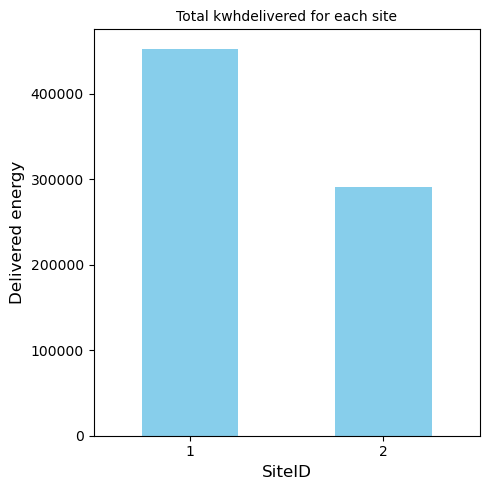

In [111]:
charging.head()
null_counts_per_site = charging.groupby('siteID')["kWhDelivered"].apply(lambda x: x.sum())
null_counts_per_site.plot(kind='bar', color='skyblue', figsize=(5, 5))

plt.title('Total kwhdelivered for each site', fontsize=10)
plt.ylabel('Delivered energy', fontsize=12)
plt.xlabel('SiteID', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [112]:
# Group by siteID and count the number of sessions
total_sessions_per_site = charging.groupby('siteID').size().reset_index(name='total_sessions')

# Display the result
print(total_sessions_per_site)

   siteID  total_sessions
0       1           32216
1       2           31408


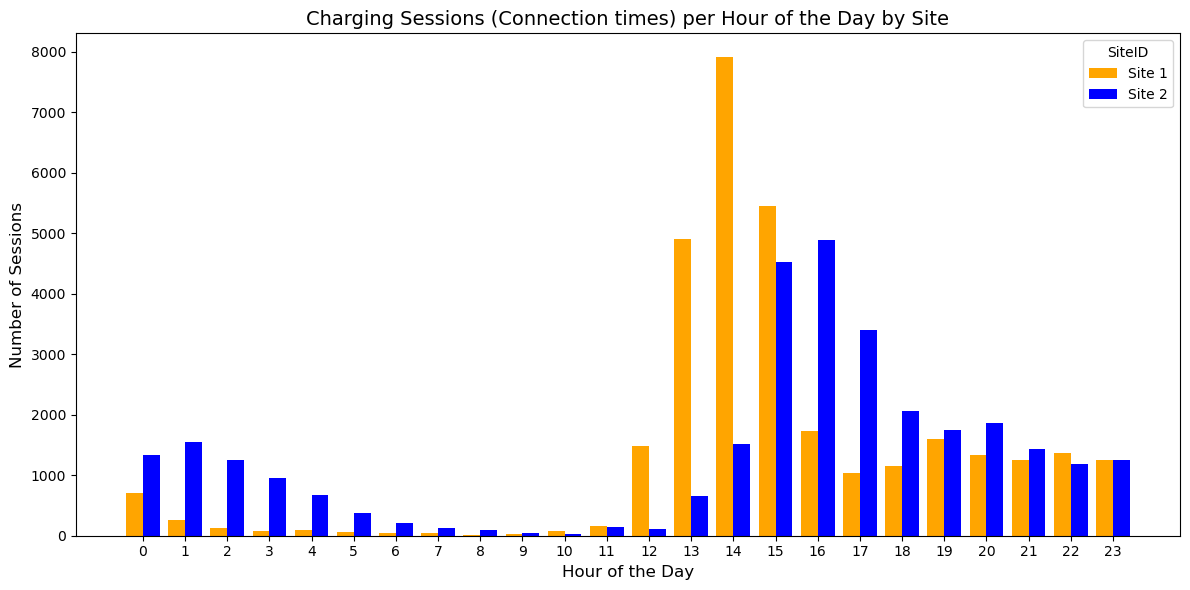

In [113]:
# Group by hour_of_day of connection time and siteID
sessions_per_hour_site = charging.groupby(['hour_of_day', 'siteID']).size().unstack(fill_value=0)

# Set up the figure
plt.figure(figsize=(12, 6))

# Define the bar width
bar_width = 0.4

# Create x positions for bars
x = np.arange(24)

# Plot bars for each siteID
plt.bar(x - bar_width / 2, sessions_per_hour_site[1], width=bar_width, label='Site 1', color='orange')
plt.bar(x + bar_width / 2, sessions_per_hour_site[2], width=bar_width, label='Site 2', color='blue')

# Add labels and title
plt.xticks(range(0, 24), range(0, 24), rotation=0)
plt.title('Charging Sessions (Connection times) per Hour of the Day by Site', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

# Add a legend
plt.legend(title='SiteID')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

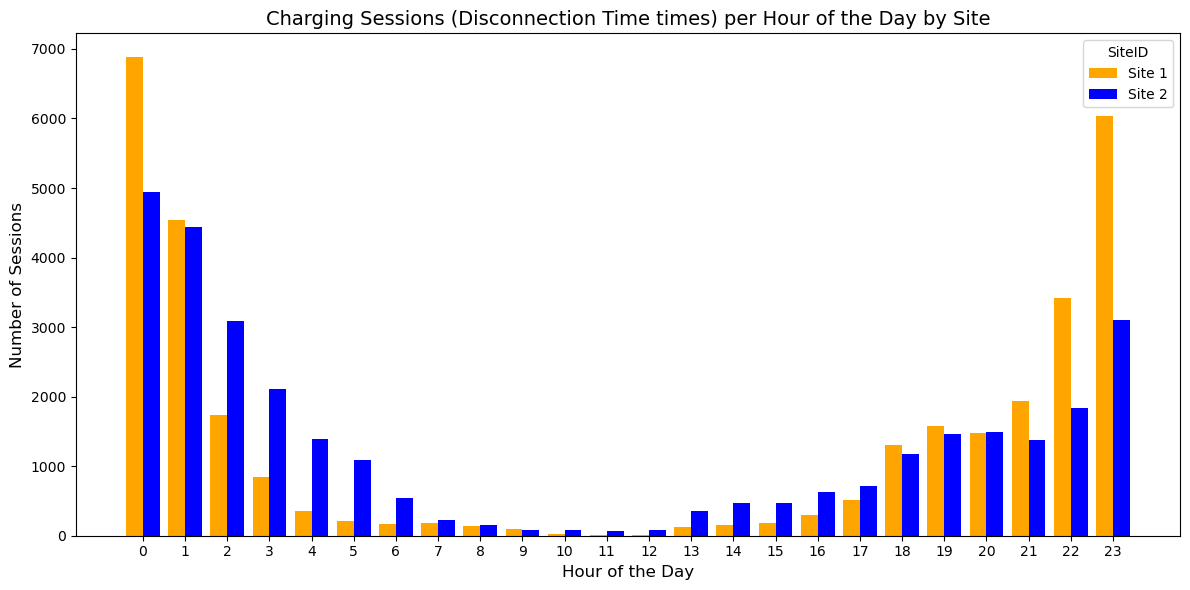

In [114]:
#Do the same for disconnectTime

charging['disconnectHour'] = charging['disconnectTime'].dt.hour
sessions_per_hour_site = charging.groupby(['disconnectHour', 'siteID']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(24)

plt.bar(x - bar_width / 2, sessions_per_hour_site[1], width=bar_width, label='Site 1', color='orange')
plt.bar(x + bar_width / 2, sessions_per_hour_site[2], width=bar_width, label='Site 2', color='blue')
plt.xticks(range(0, 24), range(0, 24), rotation=0)
plt.title('Charging Sessions (Disconnection Time times) per Hour of the Day by Site', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.legend(title='SiteID')

plt.tight_layout()
plt.show()

Because the amount of total sessions for site 1 and 2 are approximately the same, the data for the plot does not have to be normalized to be relative to each other and can be compared with their absolute values. So the peak of site 1 is significant and shows that most people charge at early afternoon

C:\Users\Willi\AppData\Local\Temp\ipykernel_12772\723593695.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_users_per_site.index, y=unique_users_per_site.values, palette="viridis")


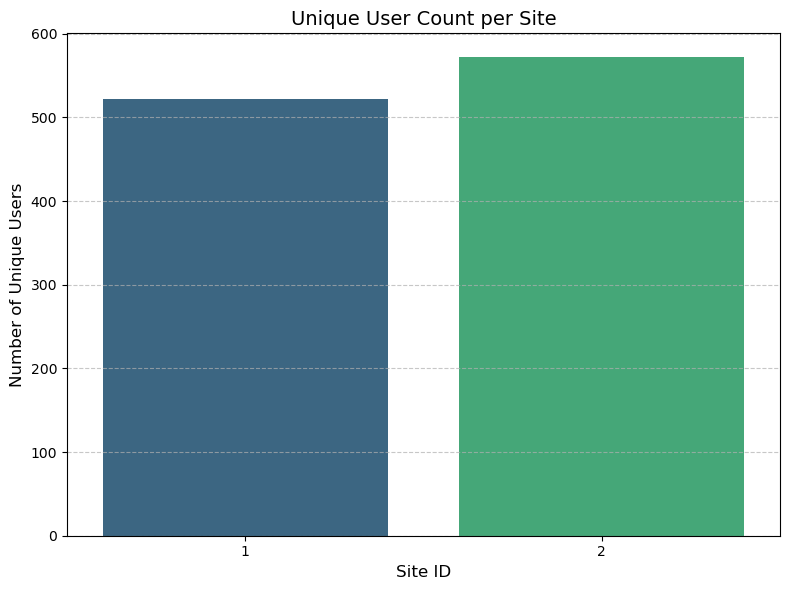

In [116]:
# Group by siteID and count unique userIDs
unique_users_per_site = charging.groupby('siteID')['userID'].nunique()

# Plot the result
plt.figure(figsize=(8, 6))
sns.barplot(x=unique_users_per_site.index, y=unique_users_per_site.values, palette="viridis")

# Customize the plot
plt.title('Unique User Count per Site', fontsize=14)
plt.xlabel('Site ID', fontsize=12)
plt.ylabel('Number of Unique Users', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Compare amount of registered users for both sites in relation to unique user count of every kind (which is comparable so we can use absolute values)